## SetUP

### Folder Zipping

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# !cp -r /content/drive/MyDrive/Data/GithubHolder/0utput_csv /content/

In [5]:
# !zip -r 0utput_csv.zip 0utput_csv

  adding: 0utput_csv/ (stored 0%)
  adding: 0utput_csv/Test Vid 1_processed.csv (deflated 55%)
  adding: 0utput_csv/Test Vid 2_processed.csv (deflated 60%)
  adding: 0utput_csv/Test Vid 7_processed.csv (deflated 59%)
  adding: 0utput_csv/Test Vid 5_processed.csv (deflated 62%)
  adding: 0utput_csv/Test Vid 3_processed.csv (deflated 60%)
  adding: 0utput_csv/Test Vid 8_processed.csv (deflated 61%)


In [6]:
# !cp 0utput_csv.zip /content/drive/MyDrive/Data/GithubHolder/

In [1]:
!gdown https://drive.google.com/uc?id=1mCFtuXa964LmFilwRuoIav5ptrVfFe1B -O /content/

Downloading...
From: https://drive.google.com/uc?id=1mCFtuXa964LmFilwRuoIav5ptrVfFe1B
To: /content/0utput_csv.zip
100% 474k/474k [00:00<00:00, 105MB/s]


In [3]:
!unzip /content/0utput_csv.zip -d /content/

Archive:  /content/0utput_csv.zip
   creating: /content/0utput_csv/
  inflating: /content/0utput_csv/Test Vid 1_processed.csv  
  inflating: /content/0utput_csv/Test Vid 2_processed.csv  
  inflating: /content/0utput_csv/Test Vid 7_processed.csv  
  inflating: /content/0utput_csv/Test Vid 5_processed.csv  
  inflating: /content/0utput_csv/Test Vid 3_processed.csv  
  inflating: /content/0utput_csv/Test Vid 8_processed.csv  


In [4]:
!ls /content/0utput_csv/

'Test Vid 1_processed.csv'  'Test Vid 5_processed.csv'
'Test Vid 2_processed.csv'  'Test Vid 7_processed.csv'
'Test Vid 3_processed.csv'  'Test Vid 8_processed.csv'


### Processing Task Distance

In [15]:
import pandas as pd
import numpy as np

# Path to your CSV
csv_path = "/content/0utput_csv/Test Vid 1_processed.csv"

# Load CSV
df = pd.read_csv(csv_path)

# Show first 5 rows
df.head(6)

,frame_id,object_id,x1,y1,x2,y2,confidence
0,0,1,816,472,959,514,0.881212
1,0,2,242,475,386,539,0.866613
2,1,1,796,482,936,526,0.825512
3,1,2,262,463,411,539,0.820025
4,2,1,773,487,914,536,0.860945
5,2,2,292,452,435,540,0.827729


In [12]:
unique_object_ids = df['object_id'].unique()
print("Unique object IDs in the CSV:", unique_object_ids)

Unique object IDs in the CSV: [1 2]


#### DIstance Travelled

In [17]:
# Calculate centroid coordinates
df['cx'] = (df['x1'] + df['x2']) / 2
df['cy'] = (df['y1'] + df['y2']) / 2

In [18]:
# Sort by object and frame
df = df.sort_values(by=['object_id', 'frame_id'])

# Shift centroid coordinates to get previous frame
df['cx_prev'] = df.groupby('object_id')['cx'].shift(1)
df['cy_prev'] = df.groupby('object_id')['cy'].shift(1)

# Calculate Euclidean distance between consecutive frames
df['dist'] = np.sqrt((df['cx'] - df['cx_prev'])**2 + (df['cy'] - df['cy_prev'])**2)

# Replace NaN (first frame) with 0
df['dist'] = df['dist'].fillna(0)

In [19]:
total_distance = df.groupby('object_id')['dist'].sum()
print("Total distance covered by each pig:")
print(total_distance)

Total distance covered by each pig:
object_id
1    6288.276973
2    6034.696753
Name: dist, dtype: float64


#### ALL Files

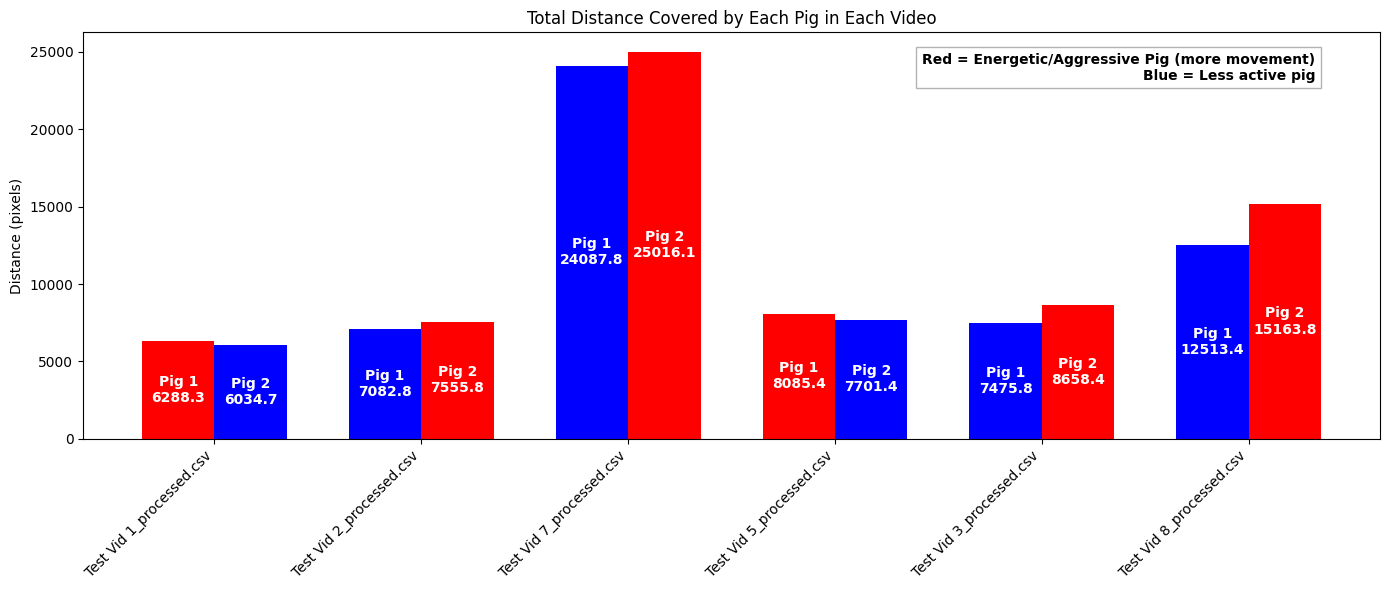

In [27]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

# --- Step 1: Get all CSV files ---
folder_path = "/content/0utput_csv/"
csv_files = glob.glob(folder_path + "*_processed.csv")

# Dictionary to store total distances
all_distances = {}

# --- Step 2: Process each CSV ---
for file in csv_files:
    df = pd.read_csv(file)

    # Calculate centroid of bounding box
    df['cx'] = (df['x1'] + df['x2']) / 2
    df['cy'] = (df['y1'] + df['y2']) / 2

    # Sort by object and frame
    df = df.sort_values(by=['object_id', 'frame_id'])

    # Previous frame centroids
    df['cx_prev'] = df.groupby('object_id')['cx'].shift(1)
    df['cy_prev'] = df.groupby('object_id')['cy'].shift(1)

    # Euclidean distance
    df['dist'] = np.sqrt((df['cx'] - df['cx_prev'])**2 + (df['cy'] - df['cy_prev'])**2)
    df['dist'] = df['dist'].fillna(0)

    # Total distance per pig in this video
    total_distance = df.groupby('object_id')['dist'].sum()
    all_distances[file.split("/")[-1]] = total_distance

# --- Step 3: Prepare data for plotting ---
labels = list(all_distances.keys())  # filenames
pig1 = [all_distances[f][1] for f in labels]  # Pig 1
pig2 = [all_distances[f][2] for f in labels]  # Pig 2

x = np.arange(len(labels))
width = 0.35

# --- Step 4: Plot bar chart ---
fig, ax = plt.subplots(figsize=(14,6))

# Determine colors based on which pig has more distance
colors_pig1 = ['red' if pig1[i] > pig2[i] else 'blue' for i in range(len(pig1))]
colors_pig2 = ['red' if pig2[i] > pig1[i] else 'blue' for i in range(len(pig2))]

# Plot bars
rects1 = ax.bar(x - width/2, pig1, width, color=colors_pig1)
rects2 = ax.bar(x + width/2, pig2, width, color=colors_pig2)

# Labels and title
ax.set_ylabel('Distance (pixels)')
ax.set_title('Total Distance Covered by Each Pig in Each Video')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')

# Annotate bars with pig label + distance inside
for rect, height in zip(rects1, pig1):
    ax.text(rect.get_x() + rect.get_width()/2, height/2, f'Pig 1\n{height:.1f}',
            ha='center', va='center', color='white', fontsize=10, fontweight='bold')
for rect, height in zip(rects2, pig2):
    ax.text(rect.get_x() + rect.get_width()/2, height/2, f'Pig 2\n{height:.1f}',
            ha='center', va='center', color='white', fontsize=10, fontweight='bold')

# --- Step 5: Add comment box inside the chart ---
ax.text(0.95, 0.95, 'Red = Energetic/Aggressive Pig (more movement)\nBlue = Less active pig',
        transform=ax.transAxes, fontsize=10, va='top', ha='right', fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray'))

plt.tight_layout()
plt.show()

In [28]:
# Save figure as high-resolution PNG
fig.savefig("/content/pig_distances.png", dpi=300, bbox_inches='tight')
print("Figure saved as /content/pig_distances.png at 300 dpi")

Figure saved as /content/pig_distances.png at 300 dpi


## Pig Movement Analysis per Video

This code calculates **movement and activity metrics** for each pig from bounding box data.

---

### 1. Import Libraries and Get CSV Files

- `pandas` → For data manipulation  
- `numpy` → For numerical calculations  
- `glob` → To list all CSV files in a folder  

---

### 2. Process Each Video CSV

- Compute **centroid** of bounding box:  
$$
cx = \frac{x_1 + x_2}{2}, \quad cy = \frac{y_1 + y_2}{2}
$$  
- Sort data by `object_id` and `frame_id`  
- Compute **previous frame centroids**: `cx_prev`, `cy_prev`  

---

### 3. Distance Calculation

- Euclidean distance between consecutive frames:  
$$
\text{distance} = \sqrt{(cx - cx_{\text{prev}})^2 + (cy - cy_{\text{prev}})^2}
$$  
- First frame distance = 0  

---

### 4. Speed Calculation

- Assuming frame rate $fps = 30$, time per frame:  
$$
\Delta t = \frac{1}{30} \text{ seconds}
$$  
- Speed:  
$$
\text{speed} = \frac{\text{distance}}{\Delta t}
$$  

---

### 5. Acceleration Calculation

- Acceleration per frame:  
$$
\text{acceleration} = \frac{\text{speed}_{\text{curr}} - \text{speed}_{\text{prev}}}{\Delta t}
$$  
- First frame acceleration = 0  

---

### 6. Active vs. Inactive Frames

- Define activity threshold (e.g., 1 pixel/frame)  
- Active: `distance > threshold`  
- Inactive: `else`  

---

### 7. Aggregate Metrics per Pig

For each `object_id`:

- **total_distance** → sum of distances  
- **average_speed** → mean speed  
- **max_speed** → maximum speed  
- **average_acceleration** → mean acceleration  
- **max_acceleration** → peak acceleration  
- **active_frames** → number of active frames  
- **total_frames** → total frames in video  

---

### 8. Display Results

- Display the summarized metrics per pig for each video CSV.


In [29]:
import pandas as pd
import numpy as np
import glob

# --- Step 1: Get all CSV files ---
folder_path = "/content/0utput_csv/"
csv_files = glob.glob(folder_path + "*_processed.csv")

# Dictionary to store results
results = {}

# --- Step 2: Process each CSV ---
for file in csv_files:
    df = pd.read_csv(file)

    # Calculate centroid of bounding box
    df['cx'] = (df['x1'] + df['x2']) / 2
    df['cy'] = (df['y1'] + df['y2']) / 2

    # Sort by object and frame
    df = df.sort_values(by=['object_id', 'frame_id'])

    # Previous frame centroids
    df['cx_prev'] = df.groupby('object_id')['cx'].shift(1)
    df['cy_prev'] = df.groupby('object_id')['cy'].shift(1)

    # --- Distance ---
    df['distance'] = np.sqrt((df['cx'] - df['cx_prev'])**2 + (df['cy'] - df['cy_prev'])**2)
    df['distance'] = df['distance'].fillna(0)

    # --- Speed ---
    # Assuming frame rate is known, e.g., 30 fps → dt = 1/30 s
    dt = 1/30
    df['speed'] = df['distance'] / dt

    # --- Acceleration ---
    df['speed_prev'] = df.groupby('object_id')['speed'].shift(1)
    df['acceleration'] = (df['speed'] - df['speed_prev']) / dt
    df['acceleration'] = df['acceleration'].fillna(0)

    # --- Active vs. inactive ---
    # Define threshold for active movement (pixels per frame)
    activity_threshold = 1  # adjust based on data scale
    df['active'] = df['distance'] > activity_threshold

    # Aggregate metrics per pig
    summary = df.groupby('object_id').agg(
        total_distance=('distance', 'sum'),
        average_speed=('speed', 'mean'),
        max_speed=('speed', 'max'),
        average_acceleration=('acceleration', 'mean'),
        max_acceleration=('acceleration', 'max'),
        active_frames=('active', 'sum'),
        total_frames=('frame_id', 'count')
    )

    # Store results
    results[file.split('/')[-1]] = summary

# --- Step 3: Display results ---
for filename, summary in results.items():
    print(f"\nFile: {filename}")
    display(summary)



File: Test Vid 1_processed.csv


,total_distance,average_speed,max_speed,average_acceleration,max_acceleration,active_frames,total_frames
object_id,,,,,,,
1,6288.276973,259.846156,1346.077635,8.874682,36660.503270,696,726
2,6034.696753,249.367634,1479.839518,1.239669,28107.998976,673,726



File: Test Vid 2_processed.csv


,total_distance,average_speed,max_speed,average_acceleration,max_acceleration,active_frames,total_frames
object_id,,,,,,,
1,7082.801499,125.581587,1156.168240,1.189398e+00,29757.76452,930,1692
2,7555.789076,133.967891,899.124574,1.021300e-14,22719.43001,1124,1692



File: Test Vid 7_processed.csv


,total_distance,average_speed,max_speed,average_acceleration,max_acceleration,active_frames,total_frames
object_id,,,,,,,
1,24087.815413,154.277212,1841.643288,0.303805,48949.298638,3392,4684
2,25016.056235,160.599548,16985.511473,0.776378,509565.344191,3348,4673



File: Test Vid 5_processed.csv


,total_distance,average_speed,max_speed,average_acceleration,max_acceleration,active_frames,total_frames
object_id,,,,,,,
1,8085.381788,147.633265,14924.841708,3.099921e-14,447108.855128,849,1643
2,7701.371965,142.442145,27760.335913,3.923527e-01,832810.077389,832,1622



File: Test Vid 3_processed.csv


,total_distance,average_speed,max_speed,average_acceleration,max_acceleration,active_frames,total_frames
object_id,,,,,,,
1,7475.790705,108.712419,1233.379504,4.384337,34297.558222,1294,2063
2,8658.372222,125.909436,986.128795,1.463253,29133.863845,1429,2063



File: Test Vid 8_processed.csv


,total_distance,average_speed,max_speed,average_acceleration,max_acceleration,active_frames,total_frames
object_id,,,,,,,
1,12513.365005,106.285660,2135.064402,-1.030005e-15,63601.932055,2103,3532
2,15163.813826,130.273315,27830.481940,2.577320e-01,834914.458193,2088,3492


## Pig Spatial Behavior Analysis

This code analyzes **home range, activity heatmaps, and zone occupancy** for pigs using bounding box data.

---

### 1. Import Libraries and Get CSV Files

- `pandas` → Data manipulation  
- `numpy` → Numerical operations  
- `matplotlib.pyplot` → Plotting home range  
- `seaborn` → Heatmaps  
- `glob` → List CSV files in folder  

---

### 2. Define Pen Zones

- Divide the pen into a **grid of zones** for occupancy analysis.  
- Example: 3×3 grid

Let:

- `pen_width`, `pen_height` → width and height of video frame  
- `x_zones`, `y_zones` → number of zones along X and Y axes  
- `x_edges = np.linspace(0, pen_width, x_zones + 1)` → edges of X zones  
- `y_edges = np.linspace(0, pen_height, y_zones + 1)` → edges of Y zones  

---

### 3. Compute Centroids

For each pig:

$$
cx = \frac{x_1 + x_2}{2}, \quad cy = \frac{y_1 + y_2}{2}
$$

- `cx`, `cy` are the **centroid coordinates** of the bounding box.  

---

### 4. Home Range Scatter Plot

- Scatter plot of all centroids per pig to visualize the **areas each pig visits**.  
- Inverted Y-axis to match video coordinate system.  

---

### 5. Activity Heatmap

- 2D histogram of centroids over pen zones:

$$
\text{heatmap}[i,j] = \text{number of frames pig was in zone } (i,j)
$$

- `np.histogram2d(cx, cy, bins=[x_edges, y_edges])` generates counts per zone.  
- `sns.heatmap` visualizes the **density of activity**.  

---

### 6. Zone Occupancy

- Assign each centroid to a zone:

$$
x_{\text{zone}} = \text{digitize}(cx, x\_edges) - 1
$$
$$
y_{\text{zone}} = \text{digitize}(cy, y\_edges) - 1
$$
$$
\text{zone\_id} = y_{\text{zone}} \cdot x\_zones + x_{\text{zone}}
$$

- Count number of frames each pig spends in each zone using `groupby`:

$$
\text{zone\_counts}[pig, zone] = \text{number of frames pig is in zone}
$$

- Results show **zone occupancy per pig** for spatial behavior analysis.  

---

### 7. Display Results

- Scatter plots for **home range**  
- Heatmaps for **activity density**  
- Tables for **zone occupancy** per pig and video


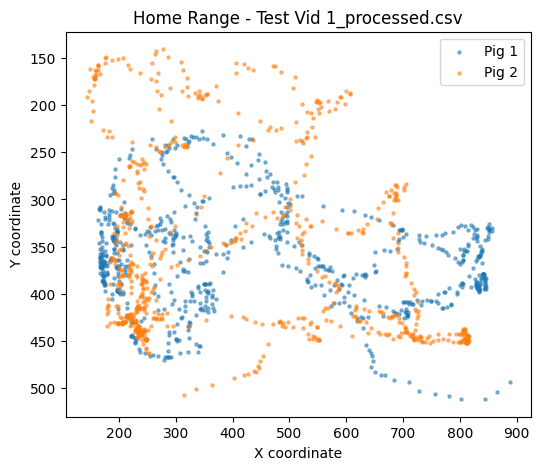

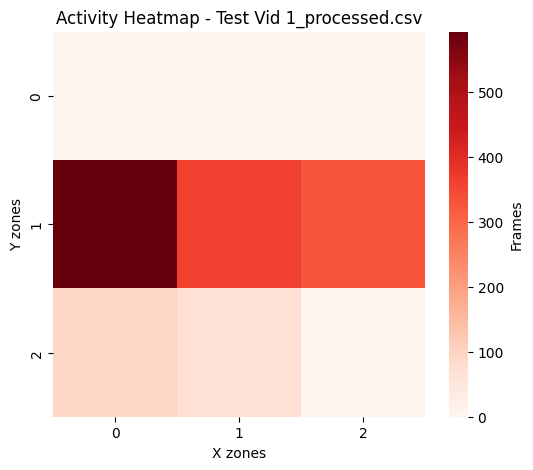


Zone Occupancy - Test Vid 1_processed.csv


zone,0,1,3,4,5
object_id,,,,,
1,22,12,298,207,187
2,72,59,295,156,144


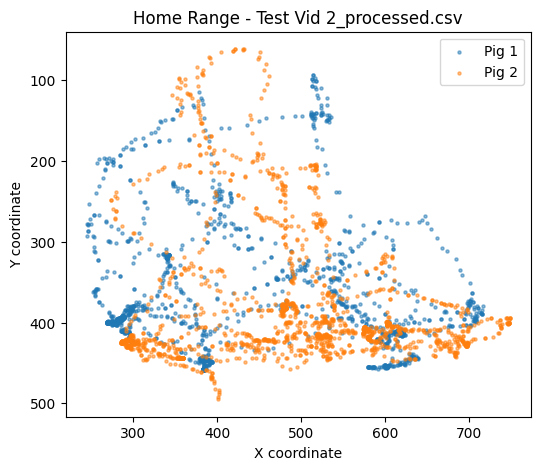

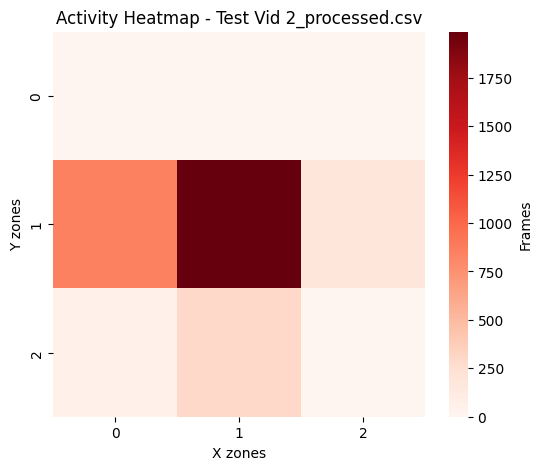


Zone Occupancy - Test Vid 2_processed.csv


zone,0,1,3,4,5
object_id,,,,,
1,44,131,615,838,64
2,12,170,239,1150,121


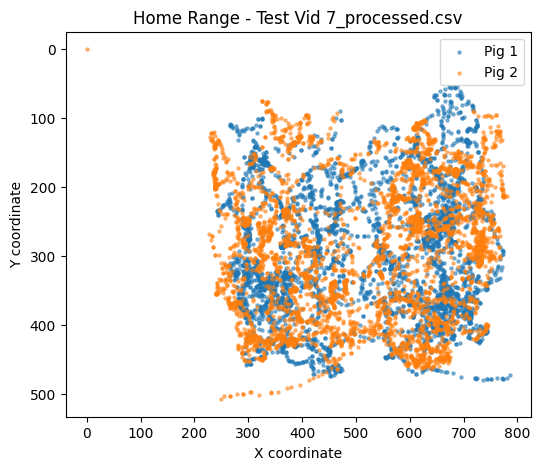

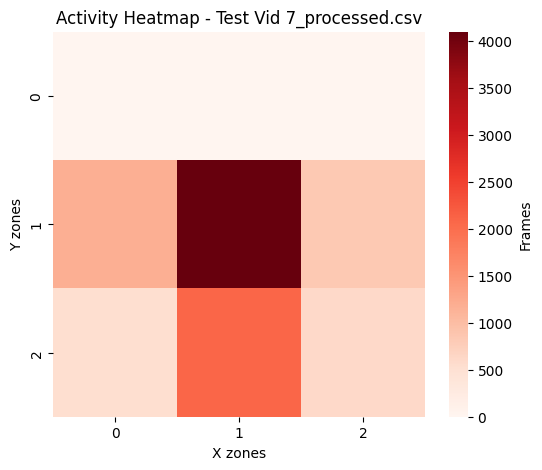


Zone Occupancy - Test Vid 7_processed.csv


zone,0,1,2,3,4,5
object_id,,,,,,
1,247,1058,223,672,2114,370
2,291,1034,385,505,1982,476


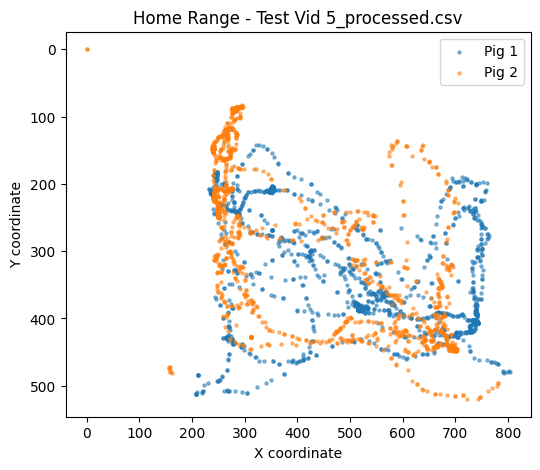

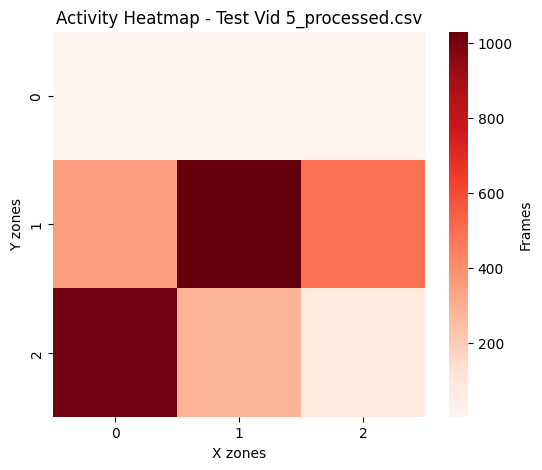


Zone Occupancy - Test Vid 5_processed.csv


zone,0,1,2,3,4,5,6,7,8
object_id,,,,,,,,,
1,165,218,64,142,640,410,4,0,0
2,848,67,12,207,390,86,0,3,9


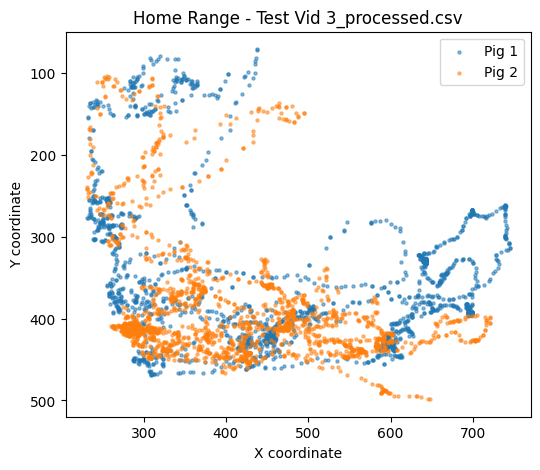

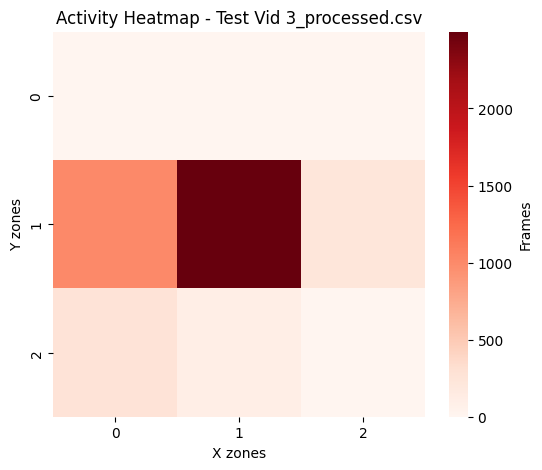


Zone Occupancy - Test Vid 3_processed.csv


zone,0,1,3,4,5
object_id,,,,,
1,151,68,397,1254,193
2,119,48,613,1244,39


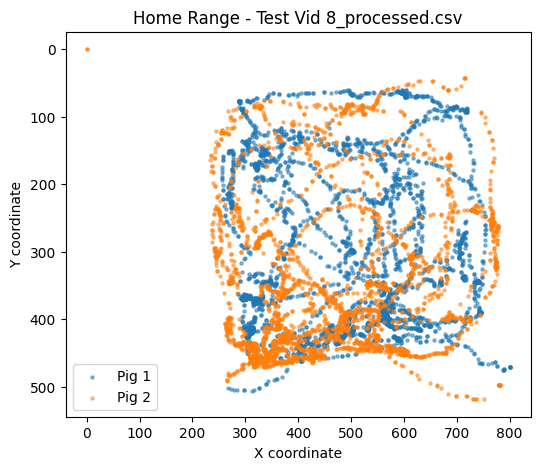

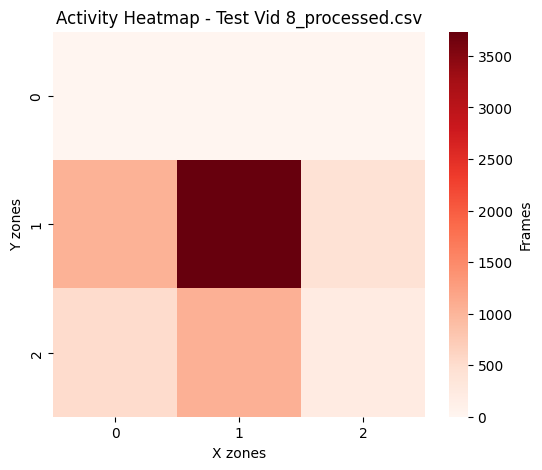


Zone Occupancy - Test Vid 8_processed.csv


zone,0,1,2,3,4,5,8
object_id,,,,,,,
1,360,720,86,373,1735,258,0
2,156,343,136,672,1999,177,9


In [30]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Get all CSV files ---
folder_path = "/content/0utput_csv/"
csv_files = glob.glob(folder_path + "*_processed.csv")

# --- Step 2: Define pen zones (example) ---
# For example, divide pen into 3x3 grid zones
pen_width = 1024   # adjust based on video width
pen_height = 768   # adjust based on video height
x_zones = 3
y_zones = 3
x_edges = np.linspace(0, pen_width, x_zones + 1)
y_edges = np.linspace(0, pen_height, y_zones + 1)

# --- Step 3: Process each CSV ---
for file in csv_files:
    df = pd.read_csv(file)

    # Compute centroids
    df['cx'] = (df['x1'] + df['x2']) / 2
    df['cy'] = (df['y1'] + df['y2']) / 2

    # --- Home range scatter ---
    plt.figure(figsize=(6,5))
    for obj_id in df['object_id'].unique():
        df_obj = df[df['object_id'] == obj_id]
        plt.scatter(df_obj['cx'], df_obj['cy'], s=5, label=f'Pig {obj_id}', alpha=0.5)
    plt.title(f'Home Range - {file.split("/")[-1]}')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.legend()
    plt.gca().invert_yaxis()  # match video coordinates
    plt.show()

    # --- Heatmap ---
    plt.figure(figsize=(6,5))
    heatmap_data, xedges, yedges = np.histogram2d(df['cx'], df['cy'], bins=[x_edges, y_edges])
    sns.heatmap(heatmap_data.T[::-1], cmap='Reds', cbar_kws={'label':'Frames'})
    plt.title(f'Activity Heatmap - {file.split("/")[-1]}')
    plt.xlabel('X zones')
    plt.ylabel('Y zones')
    plt.show()

    # --- Zone occupancy ---
    df['x_zone'] = np.digitize(df['cx'], x_edges) - 1
    df['y_zone'] = np.digitize(df['cy'], y_edges) - 1
    df['zone'] = df['y_zone']*x_zones + df['x_zone']  # unique zone id
    zone_counts = df.groupby(['object_id', 'zone']).size().unstack(fill_value=0)

    print(f"\nZone Occupancy - {file.split('/')[-1]}")
    display(zone_counts)

## Pig Interaction Analysis

This code analyzes **proximity interactions, following behavior, and collision/overlap events** between pigs based on bounding box data.

---

### 1. Import Libraries and Get CSV Files

- `pandas` → Data manipulation  
- `numpy` → Numerical calculations  
- `glob` → List all CSV files in folder  

---

### 2. Parameters

- `proximity_threshold` → maximum distance in pixels for an **interaction event**  
- `direction_cos_threshold` → cosine similarity threshold to detect **following behavior**  

---

### 3. Compute Centroids

For each pig:

$$
cx = \frac{x_1 + x_2}{2}, \quad cy = \frac{y_1 + y_2}{2}
$$

- `cx`, `cy` are the centroid coordinates of the bounding box.  

---

### 4. Proximity Interactions

- For each frame, compute the distance between pig centroids:  

$$
\text{distance}_{ij} = \sqrt{(cx_i - cx_j)^2 + (cy_i - cy_j)^2}
$$

- Count as an **interaction** if `distance_ij <= proximity_threshold`.  
- Aggregate total interaction frames per pig pair.  

---

### 5. Direction-aware Following Behavior

- For each pig pair `(i,j)` in consecutive frames:  
  - **Follower movement vector**:  
  $$
  \vec{v_i} = (cx_i^{t} - cx_i^{t-1},\ cy_i^{t} - cy_i^{t-1})
  $$  
  - **Vector to leader**:  
  $$
  \vec{d_{ij}} = (cx_j^{t} - cx_i^{t},\ cy_j^{t} - cy_i^{t})
  $$  
  - Cosine similarity:  
  $$
  \cos\theta = \frac{\vec{v_i} \cdot \vec{d_{ij}}}{||\vec{v_i}||\ ||\vec{d_{ij}}||}
  $$  
- Count as **following** if `cosθ > direction_cos_threshold`.  
- Aggregate **frames of following behavior** per pig pair.  

---

### 6. Collision / Overlap Detection

- For each frame, check **bounding box overlaps**:  

Collision occurs if:

$$
x1_i < x2_j \ \text{and} \ x2_i > x1_j \ \text{and} \ y1_i < y2_j \ \text{and} \ y2_i > y1_j
$$

- Count the number of frames each pig pair **collides or overlaps**.  

---

### 7. Display Results

- **Proximity interactions** → total frames pigs are close  
- **Following events** → frames where one pig moves toward another  
- **Collision / Overlap events** → frames where bounding boxes intersect  

Results are printed per video and per pig pair.


In [34]:
import pandas as pd
import numpy as np
import glob

# --- Step 1: Get all CSV files ---
folder_path = "/content/0utput_csv/"
csv_files = glob.glob(folder_path + "*_processed.csv")

# Parameters
proximity_threshold = 50  # pixels, for interaction events
direction_cos_threshold = 0.8  # cosine threshold to count following

# --- Step 2: Process each CSV ---
for file in csv_files:
    df = pd.read_csv(file)

    # Compute centroids
    df['cx'] = (df['x1'] + df['x2']) / 2
    df['cy'] = (df['y1'] + df['y2']) / 2

    frames = df['frame_id'].unique()
    pig_ids = df['object_id'].unique()

    # --- Proximity Analysis ---
    interaction_counts = { (i,j): 0 for i in pig_ids for j in pig_ids if i < j }
    for f in frames:
        df_frame = df[df['frame_id'] == f]
        pigs = df_frame['object_id'].values
        coords = df_frame[['cx','cy']].values
        for i in range(len(pigs)):
            for j in range(i+1, len(pigs)):
                dist = np.linalg.norm(coords[i]-coords[j])
                if dist <= proximity_threshold:
                    interaction_counts[(pigs[i], pigs[j])] += 1
    print(f"\nProximity Interactions - {file.split('/')[-1]}")
    for pair, count in interaction_counts.items():
        print(f"Pigs {pair[0]} & {pair[1]}: {count} interaction frames")

    # --- Direction-aware Following Behavior ---
    following_events = { (i,j): 0 for i in pig_ids for j in pig_ids if i != j }

    for f in frames[1:]:
        df_prev = df[df['frame_id'] == f-1].set_index('object_id')
        df_curr = df[df['frame_id'] == f].set_index('object_id')

        for i in pig_ids:
            for j in pig_ids:
                if i == j:
                    continue
                # Only consider if both pigs exist in both frames
                if i in df_prev.index and j in df_prev.index and i in df_curr.index and j in df_curr.index:
                    # Follower movement vector
                    v_i = np.array([df_curr.loc[i]['cx'] - df_prev.loc[i]['cx'],
                                    df_curr.loc[i]['cy'] - df_prev.loc[i]['cy']])
                    # Vector from follower to leader
                    d_ij = np.array([df_curr.loc[j]['cx'] - df_curr.loc[i]['cx'],
                                     df_curr.loc[j]['cy'] - df_curr.loc[i]['cy']])
                    if np.linalg.norm(v_i) > 0 and np.linalg.norm(d_ij) > 0:
                        cos_theta = np.dot(v_i, d_ij) / (np.linalg.norm(v_i)*np.linalg.norm(d_ij))
                        if cos_theta > direction_cos_threshold:
                            following_events[(i,j)] += 1
    print(f"\nFollowing Events - {file.split('/')[-1]}")
    for pair, count in following_events.items():
        print(f"Pig {pair[0]} following Pig {pair[1]}: {count} frames")

    # --- Collision / Overlap Detection ---
    collision_counts = { (i,j): 0 for i in pig_ids for j in pig_ids if i < j }
    for f in frames:
        df_frame = df[df['frame_id'] == f]
        pigs = df_frame['object_id'].values
        boxes = df_frame[['x1','y1','x2','y2']].values
        for i in range(len(pigs)):
            for j in range(i+1, len(pigs)):
                # Check overlap
                if (boxes[i][0] < boxes[j][2] and boxes[i][2] > boxes[j][0] and
                    boxes[i][1] < boxes[j][3] and boxes[i][3] > boxes[j][1]):
                    collision_counts[(pigs[i], pigs[j])] += 1
    print(f"\nCollision / Overlap Events - {file.split('/')[-1]}")
    for pair, count in collision_counts.items():
        print(f"""Pigs {pair[0]} & {pair[1]}: {count} frames
        \n\n ------------------------------------------------\n""")


Proximity Interactions - Test Vid 1_processed.csv
Pigs 1 & 2: 21 interaction frames

Following Events - Test Vid 1_processed.csv
Pig 1 following Pig 2: 126 frames
Pig 2 following Pig 1: 130 frames

Collision / Overlap Events - Test Vid 1_processed.csv
Pigs 1 & 2: 690 frames
        
 ------------------------------------------------


Proximity Interactions - Test Vid 2_processed.csv
Pigs 1 & 2: 8 interaction frames

Following Events - Test Vid 2_processed.csv
Pig 1 following Pig 2: 344 frames
Pig 2 following Pig 1: 270 frames

Collision / Overlap Events - Test Vid 2_processed.csv
Pigs 1 & 2: 1096 frames
        
 ------------------------------------------------


Proximity Interactions - Test Vid 7_processed.csv
Pigs 1 & 2: 83 interaction frames

Following Events - Test Vid 7_processed.csv
Pig 1 following Pig 2: 771 frames
Pig 2 following Pig 1: 785 frames

Collision / Overlap Events - Test Vid 7_processed.csv
Pigs 1 & 2: 4591 frames
        
 -----------------------------------------

## Pig Social & Aggressive Behavior Analysis

This code detects **aggressive behavior** and **dominance patterns** for each pig based on bounding box and movement data.

---

### 1. Import Libraries and Load CSV Files

- `pandas` → Data manipulation  
- `numpy` → Numerical operations  
- `glob` → List all processed CSV files  

---

### 2. Parameters

- `speed_threshold` → pixels/frame to consider **rapid movement** as aggressive  
- `proximity_threshold` → pixels for overlap detection  
- Pen dimensions: `pen_width`, `pen_height`  
- Grid zones for dominance: `x_zones × y_zones`  
- Zone edges: `x_edges = np.linspace(0, pen_width, x_zones+1)` and `y_edges = np.linspace(0, pen_height, y_zones+1)`  

---

### 3. Compute Centroids and Speed

- Centroid of bounding box:  
$$
cx = \frac{x_1 + x_2}{2}, \quad cy = \frac{y_1 + y_2}{2}
$$

- Previous frame centroids: `cx_prev`, `cy_prev`  
- Speed per frame:  
$$
\text{speed} = \sqrt{(cx - cx_{\text{prev}})^2 + (cy - cy_{\text{prev}})^2}
$$

---

### 4. Aggression Detection

- Rapid movement **and** bounding box overlap with another pig is counted as an **aggressive event**.  
- Overlap condition for two bounding boxes `(x1,y1,x2,y2)` and `(x1',y1',x2',y2')`:

$$
x1 < x2' \ \text{and} \ x2 > x1' \ \text{and} \ y1 < y2' \ \text{and} \ y2 > y1'
$$

- Count **aggressive frames** per pig per video.  

---

### 5. Dominance Patterns via Zone Occupancy

- Divide pen into grid zones.  
- Assign each centroid to a zone:

$$
x_{\text{zone}} = \text{digitize}(cx, x\_edges) - 1
$$
$$
y_{\text{zone}} = \text{digitize}(cy, y\_edges) - 1
$$
$$
\text{zone\_id} = y_{\text{zone}} \cdot x\_zones + x_{\text{zone}}
$$

- Count **unique zones occupied** by each pig to estimate dominance or territorial behavior.  

---

### 6. Display Results

- **Aggressive Events:** Number of frames each pig moved rapidly towards others while overlapping.  
- **Dominance Patterns:** Number of unique zones each pig occupied during the video.  


In [35]:
import pandas as pd
import numpy as np
import glob

# --- Step 1: Load CSV files ---
folder_path = "/content/0utput_csv/"
csv_files = glob.glob(folder_path + "*_processed.csv")

# Parameters
speed_threshold = 20  # pixels/frame, adjust based on scale
proximity_threshold = 50  # pixels for overlap
pen_width = 1024
pen_height = 768
x_zones = 3
y_zones = 3
x_edges = np.linspace(0, pen_width, x_zones+1)
y_edges = np.linspace(0, pen_height, y_zones+1)

# --- Step 2: Process each CSV ---
for file in csv_files:
    df = pd.read_csv(file)

    # Centroids
    df['cx'] = (df['x1'] + df['x2']) / 2
    df['cy'] = (df['y1'] + df['y2']) / 2

    # Previous frame centroids
    df = df.sort_values(by=['object_id', 'frame_id'])
    df['cx_prev'] = df.groupby('object_id')['cx'].shift(1)
    df['cy_prev'] = df.groupby('object_id')['cy'].shift(1)

    # Speed
    df['speed'] = np.sqrt((df['cx'] - df['cx_prev'])**2 + (df['cy'] - df['cy_prev'])**2)
    df['speed'] = df['speed'].fillna(0)

    pig_ids = df['object_id'].unique()

    # --- Aggression Detection ---
    aggressive_events = { i: 0 for i in pig_ids }

    frames = df['frame_id'].unique()
    for f in frames:
        df_frame = df[df['frame_id'] == f].set_index('object_id')
        pigs = df_frame.index.tolist()
        for i in pigs:
            # Check rapid movement
            if df_frame.loc[i]['speed'] > speed_threshold:
                # Check overlap with any other pig
                for j in pigs:
                    if i == j:
                        continue
                    # Overlap condition
                    box_i = df_frame.loc[i][['x1','y1','x2','y2']].values
                    box_j = df_frame.loc[j][['x1','y1','x2','y2']].values
                    if (box_i[0] < box_j[2] and box_i[2] > box_j[0] and
                        box_i[1] < box_j[3] and box_i[3] > box_j[1]):
                        aggressive_events[i] += 1

    print(f"\nAggressive Events - {file.split('/')[-1]}")
    for pig, count in aggressive_events.items():
        print(f"Pig {pig}: {count} aggressive frames")

    # --- Dominance Patterns via Zone Occupancy ---
    df['x_zone'] = np.digitize(df['cx'], x_edges) - 1
    df['y_zone'] = np.digitize(df['cy'], y_edges) - 1
    df['zone'] = df['y_zone']*x_zones + df['x_zone']

    zone_counts = df.groupby('object_id')['zone'].nunique()

    print(f"\nDominance Patterns (unique zones occupied) - {file.split('/')[-1]}")
    for pig, zones in zone_counts.items():
        print(f"Pig {pig}: {zones} unique zones")


Aggressive Events - Test Vid 1_processed.csv
Pig 1: 41 aggressive frames
Pig 2: 53 aggressive frames

Dominance Patterns (unique zones occupied) - Test Vid 1_processed.csv
Pig 1: 5 unique zones
Pig 2: 5 unique zones

Aggressive Events - Test Vid 2_processed.csv
Pig 1: 55 aggressive frames
Pig 2: 31 aggressive frames

Dominance Patterns (unique zones occupied) - Test Vid 2_processed.csv
Pig 1: 5 unique zones
Pig 2: 5 unique zones

Aggressive Events - Test Vid 7_processed.csv
Pig 1: 116 aggressive frames
Pig 2: 133 aggressive frames

Dominance Patterns (unique zones occupied) - Test Vid 7_processed.csv
Pig 1: 6 unique zones
Pig 2: 6 unique zones

Aggressive Events - Test Vid 5_processed.csv
Pig 1: 53 aggressive frames
Pig 2: 52 aggressive frames

Dominance Patterns (unique zones occupied) - Test Vid 5_processed.csv
Pig 1: 7 unique zones
Pig 2: 8 unique zones

Aggressive Events - Test Vid 3_processed.csv
Pig 1: 18 aggressive frames
Pig 2: 16 aggressive frames

Dominance Patterns (unique 

## Temporal Patterns Analysis for Pigs

This code visualizes **activity over time, interaction frequency, and behavioral rhythms** for pigs in each video.

---

### 1. Import Libraries and Load CSV Files

- `pandas` → Data manipulation  
- `numpy` → Numerical calculations  
- `glob` → List all processed CSV files  
- `matplotlib.pyplot` → Plot temporal patterns  

---

### 2. Parameters

- `proximity_threshold` → pixels for counting interactions  
- `fps` → frames per second of the video, used for rolling window calculations  

---

### 3. Compute Centroids and Distance per Frame

- Centroid of bounding box:  
$$
cx = \frac{x_1 + x_2}{2}, \quad cy = \frac{y_1 + y_2}{2}
$$

- Distance between consecutive frames:  
$$
\text{distance}_t = \sqrt{(cx_t - cx_{t-1})^2 + (cy_t - cy_{t-1})^2}
$$

- First frame distance = 0  

---

### 4. Activity Over Time

- Plot **distance traveled per frame** for each pig  
- Smooth with a rolling average (window=5 frames)  
- X-axis: frame number, Y-axis: distance (pixels)  

---

### 5. Interaction Frequency Over Time

- For each frame, compute pairwise distances between pigs:  
$$
\text{distance}_{ij} = \sqrt{(cx_i - cx_j)^2 + (cy_i - cy_j)^2}
$$

- Count **interaction events** where distance ≤ `proximity_threshold`  
- Apply rolling sum over `fps` frames (~1 second) to show **interactions per second**  

---

### 6. Behavioral Rhythms (Active vs Resting)

- Use **rolling average distance** to detect periods of high vs low activity  
- Window size: `fps * 10` frames (~10 seconds smoothing)  
- Helps visualize **recurrent patterns** like resting, exploring, or feeding  

---

### 7. Display Results

- Line plots per pig for:
  - **Activity over time**  
  - **Interaction frequency**  
  - **Behavioral rhythms**


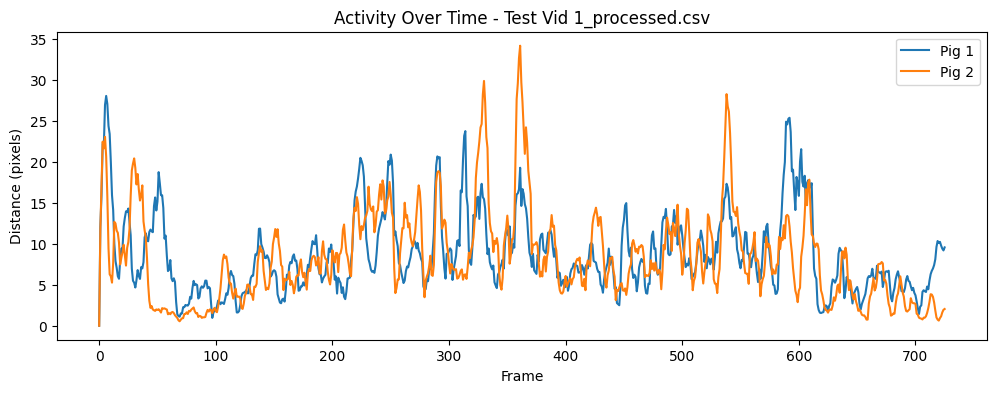

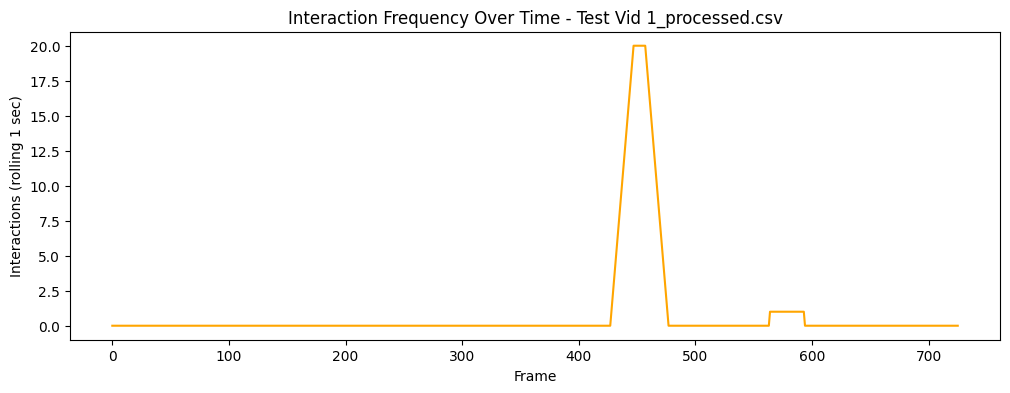

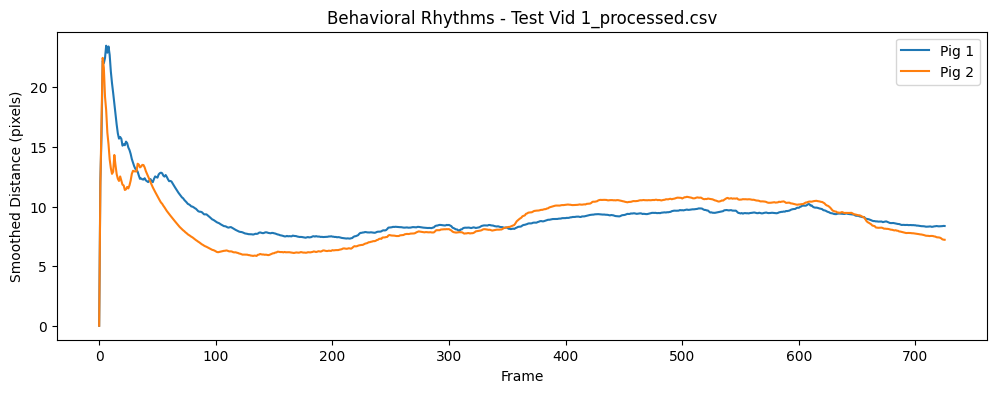

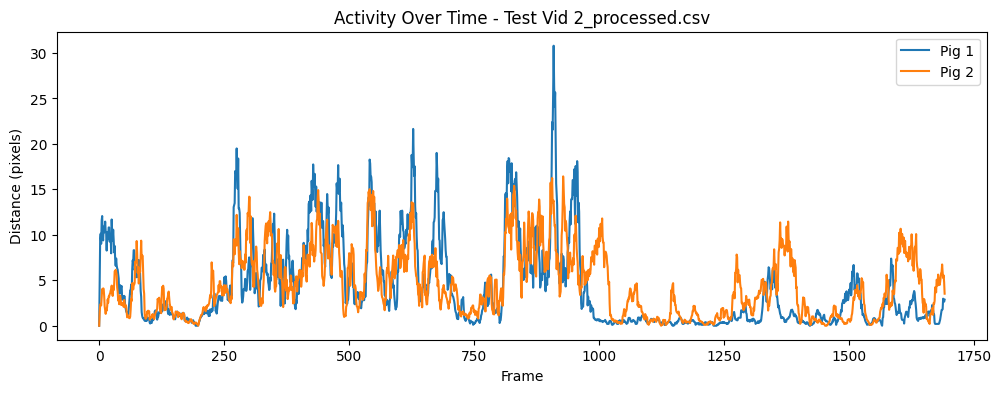

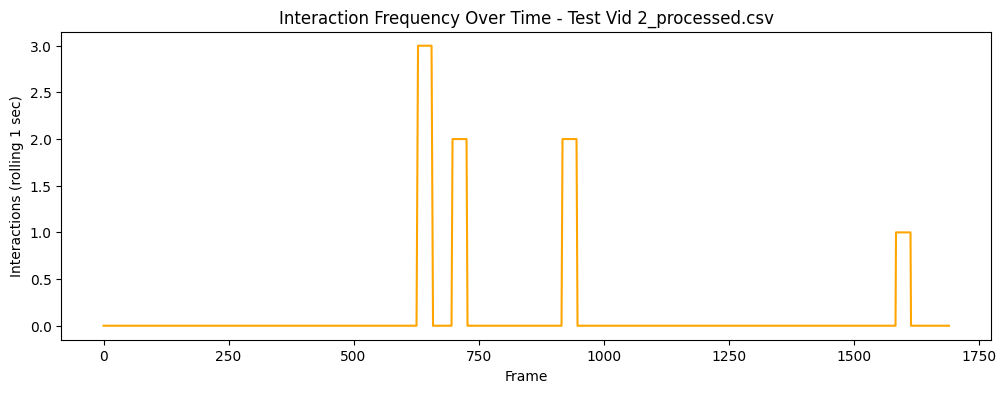

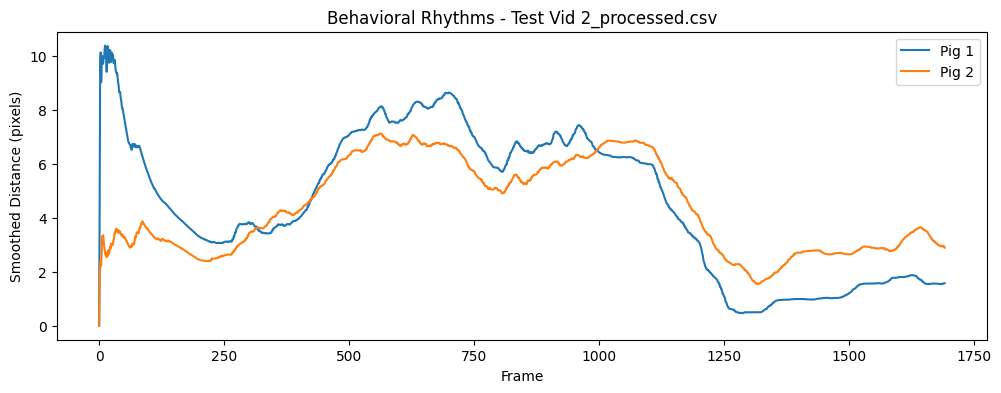

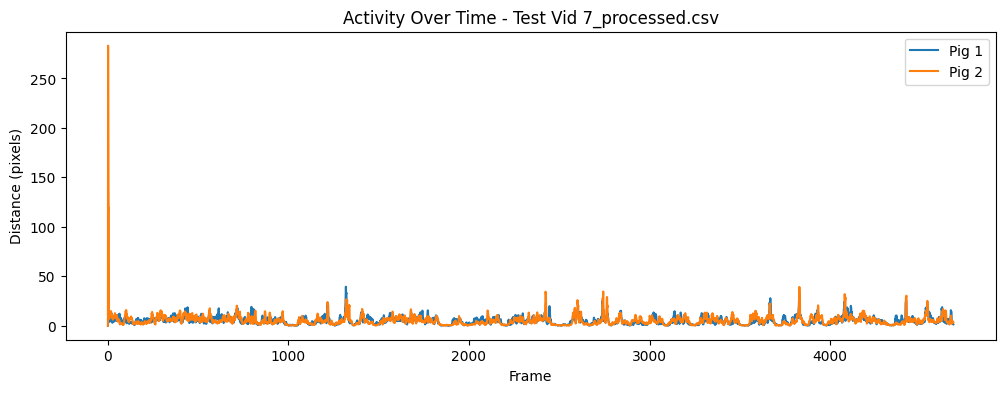

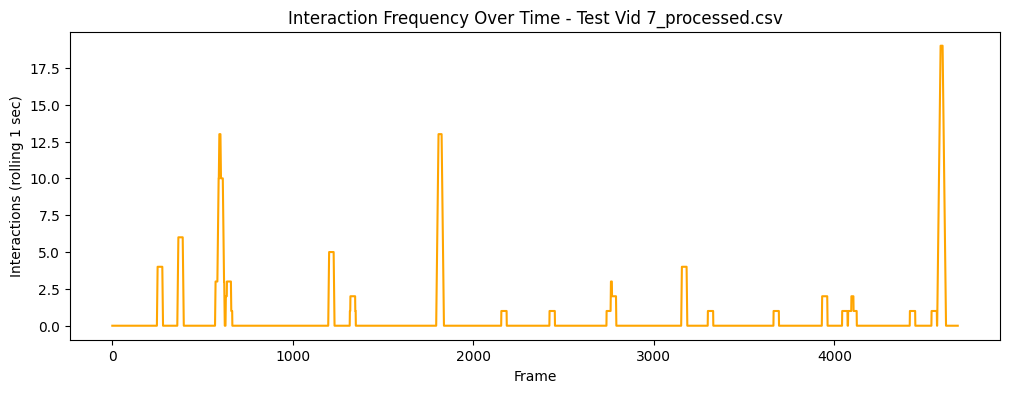

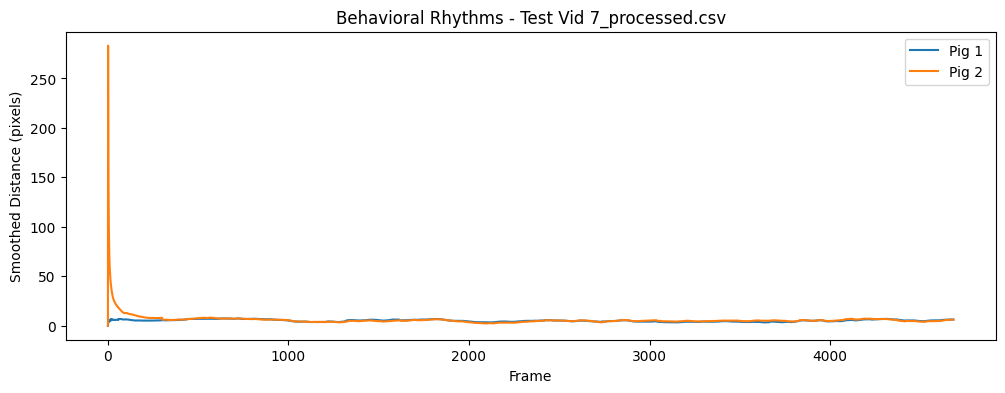

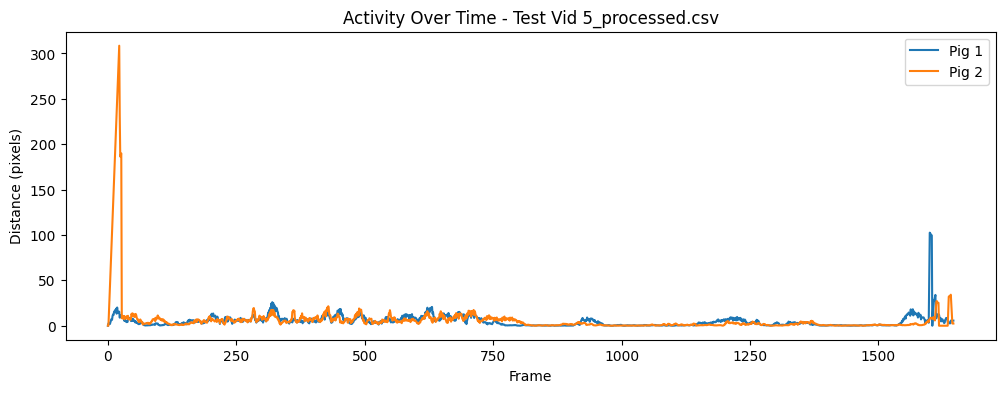

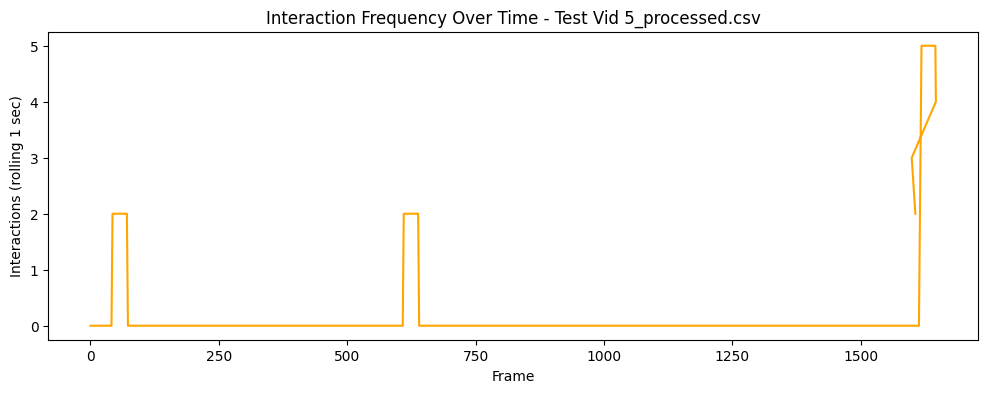

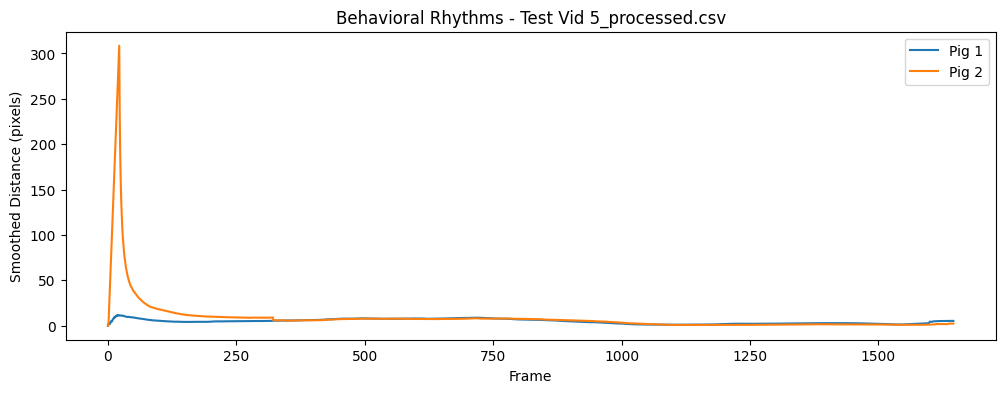

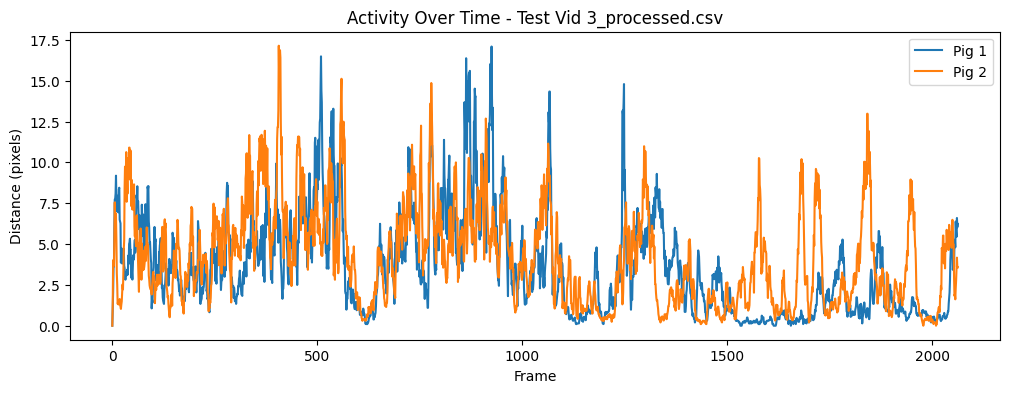

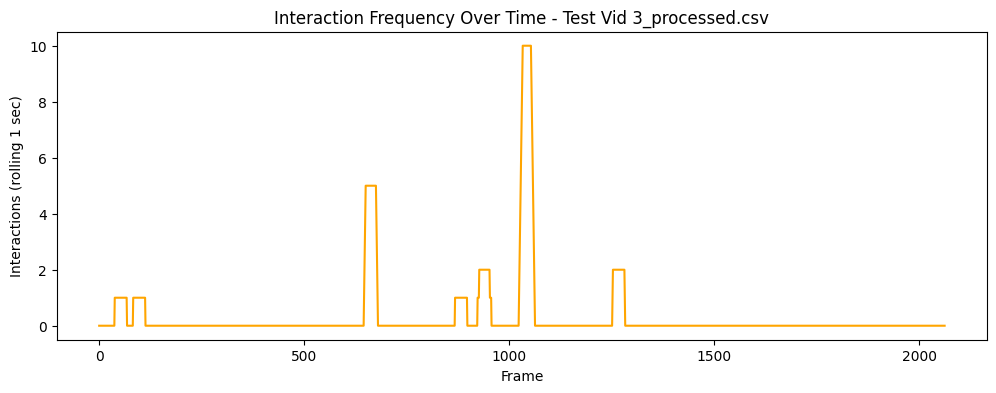

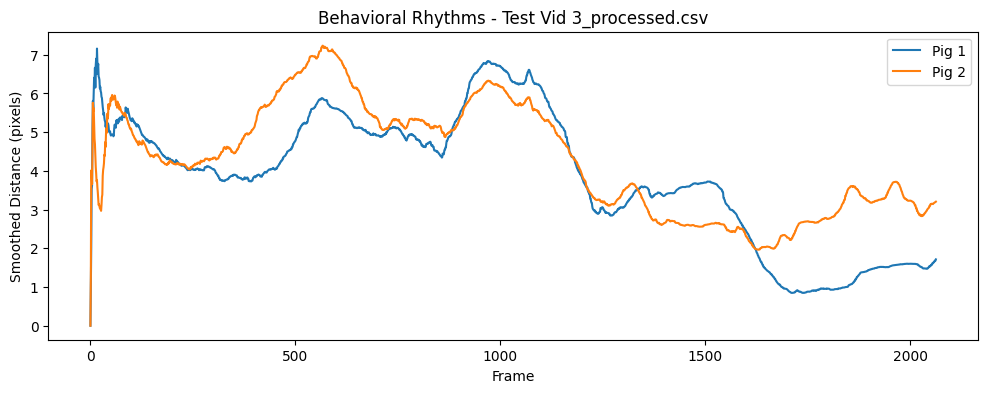

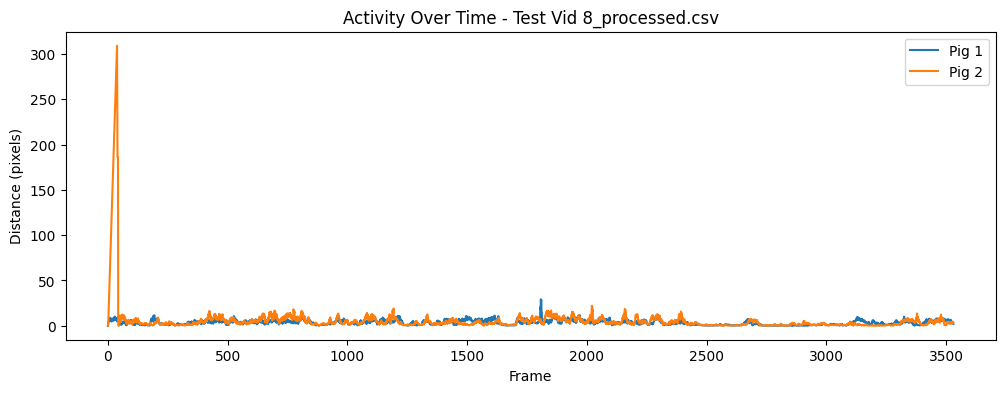

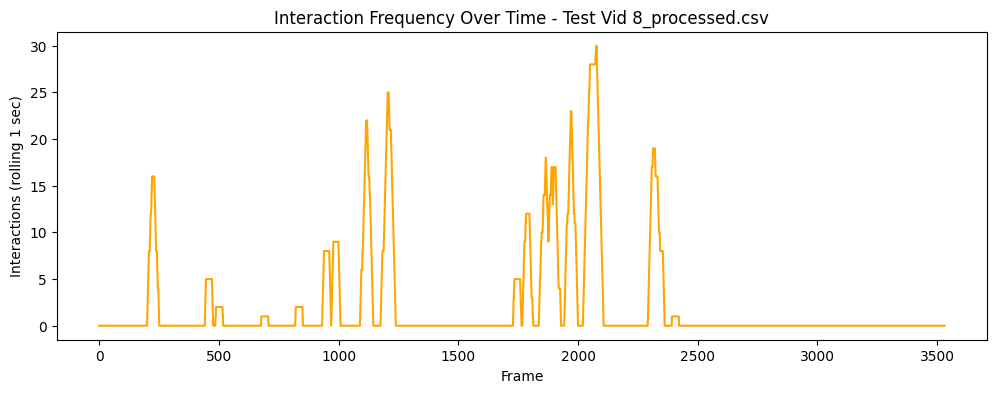

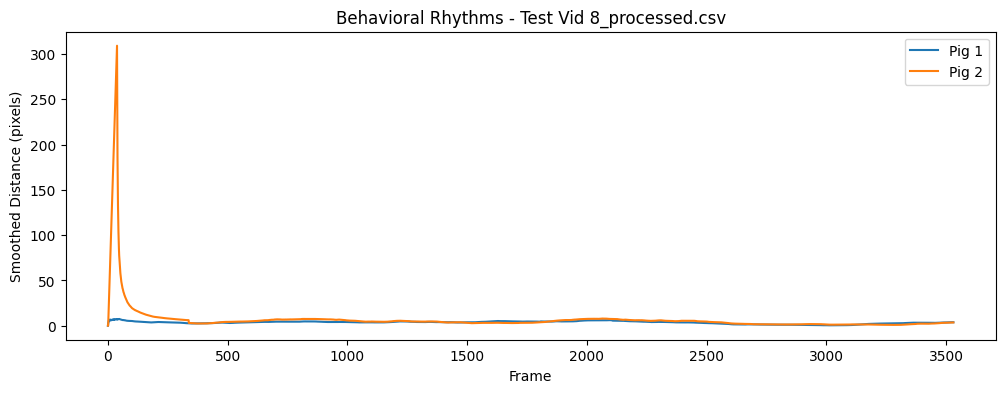

In [36]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

# --- Step 1: Load CSV files ---
folder_path = "/content/0utput_csv/"
csv_files = glob.glob(folder_path + "*_processed.csv")

# Parameters
proximity_threshold = 50  # pixels for interaction events
fps = 30  # frames per second

# --- Step 2: Process each CSV ---
for file in csv_files:
    df = pd.read_csv(file)

    # Compute centroids
    df['cx'] = (df['x1'] + df['x2']) / 2
    df['cy'] = (df['y1'] + df['y2']) / 2

    # Sort by object and frame
    df = df.sort_values(by=['object_id','frame_id'])

    # Compute distance per frame
    df['cx_prev'] = df.groupby('object_id')['cx'].shift(1)
    df['cy_prev'] = df.groupby('object_id')['cy'].shift(1)
    df['distance'] = np.sqrt((df['cx'] - df['cx_prev'])**2 + (df['cy'] - df['cy_prev'])**2)
    df['distance'] = df['distance'].fillna(0)

    pig_ids = df['object_id'].unique()

    # --- Activity Over Time ---
    plt.figure(figsize=(12,4))
    for pig in pig_ids:
        df_pig = df[df['object_id']==pig]
        plt.plot(df_pig['frame_id'], df_pig['distance'].rolling(5, min_periods=1).mean(), label=f'Pig {pig}')
    plt.xlabel('Frame')
    plt.ylabel('Distance (pixels)')
    plt.title(f'Activity Over Time - {file.split("/")[-1]}')
    plt.legend()
    plt.show()

    # --- Interaction Frequency Over Time ---
    frames = df['frame_id'].unique()
    interaction_counts = []

    for f in frames:
        df_frame = df[df['frame_id']==f]
        pigs = df_frame['object_id'].values
        coords = df_frame[['cx','cy']].values
        count = 0
        for i in range(len(pigs)):
            for j in range(i+1, len(pigs)):
                dist = np.linalg.norm(coords[i]-coords[j])
                if dist <= proximity_threshold:
                    count += 1
        interaction_counts.append(count)

    plt.figure(figsize=(12,4))
    plt.plot(frames, pd.Series(interaction_counts).rolling(fps, min_periods=1).sum(), color='orange')
    plt.xlabel('Frame')
    plt.ylabel('Interactions (rolling 1 sec)')
    plt.title(f'Interaction Frequency Over Time - {file.split("/")[-1]}')
    plt.show()

    # --- Behavioral Rhythms (simplified) ---
    # Using rolling average distance to detect active vs resting periods
    plt.figure(figsize=(12,4))
    for pig in pig_ids:
        df_pig = df[df['object_id']==pig]
        rolling_speed = df_pig['distance'].rolling(fps*10, min_periods=1).mean()  # ~10 seconds smoothing
        plt.plot(df_pig['frame_id'], rolling_speed, label=f'Pig {pig}')
    plt.xlabel('Frame')
    plt.ylabel('Smoothed Distance (pixels)')
    plt.title(f'Behavioral Rhythms - {file.split("/")[-1]}')
    plt.legend()
    plt.show()


## Group Dynamics Analysis for Pigs

This code analyzes **group clustering, density, and aggressive movement toward other pigs**.

---

### 1. Import Libraries and Load CSV Files

- `pandas`, `numpy` → Data manipulation and calculations  
- `glob` → List all processed CSV files  
- `matplotlib.pyplot` → Plot temporal dynamics  
- `sklearn.cluster.DBSCAN` → Detect groups/clusters  

---

### 2. Parameters

- `speed_threshold` → pixels/frame to define **fast movement**  
- `proximity_threshold` → pixels for interaction or overlap  
- `eps_cluster` → DBSCAN distance threshold to form clusters  
- `min_samples` → minimum number of pigs to form a cluster  

---

### 3. Compute Centroids and Speed

- Centroid of bounding box:  
$$
cx = \frac{x_1 + x_2}{2}, \quad cy = \frac{y_1 + y_2}{2}
$$

- Speed per frame:  
$$
\text{speed} = \sqrt{(cx - cx_{\text{prev}})^2 + (cy - cy_{\text{prev}})^2}
$$

---

### 4. Group Clustering & Density

- **DBSCAN** applied per frame to find clusters of pigs:  
  - `num_clusters = number of unique DBSCAN labels excluding -1`  
- **Density estimation:** maximum number of pigs in a 100×100 grid per frame  

---

### 5. Aggressive Movement Toward Others

- For each pig `i` in consecutive frames:  
  - Movement vector:  
  $$
  \vec{v_i} = (cx_i^t - cx_i^{t-1},\ cy_i^t - cy_i^{t-1})
  $$  
  - Speed check: `||v_i|| >= speed_threshold`  
  - Vector toward other pig `j`:  
  $$
  \vec{d_{ij}} = (cx_j^t - cx_i^t, cy_j^t - cy_i^t)
  $$  
  - Cosine similarity:  
  $$
  \cos\theta = \frac{\vec{v_i} \cdot \vec{d_{ij}}}{||\vec{v_i}|| \ ||\vec{d_{ij}}||}
  $$  
  - Count as **aggressive toward another pig** if `cosθ > 0.8`  

---

### 6. Display Results

- Line plots per frame for:
  - **Number of clusters** over time  
  - **Maximum density per grid** over time  

- Print **number of frames each pig moved aggressively toward other pigs**  


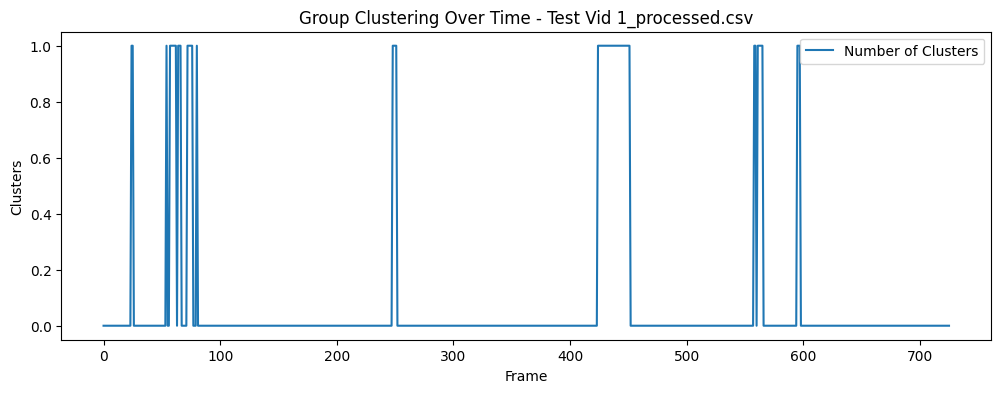

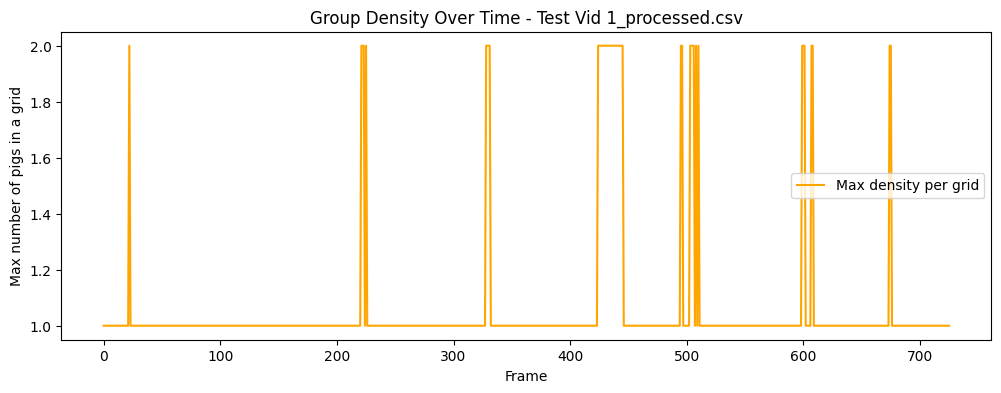


Aggressive Movements Toward Others - Test Vid 1_processed.csv
Pig 1: 17 frames moving aggressively toward others
Pig 2: 13 frames moving aggressively toward others


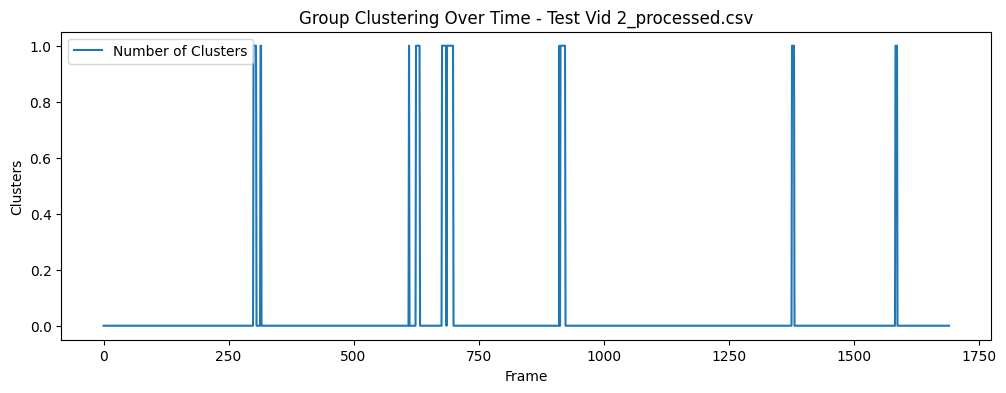

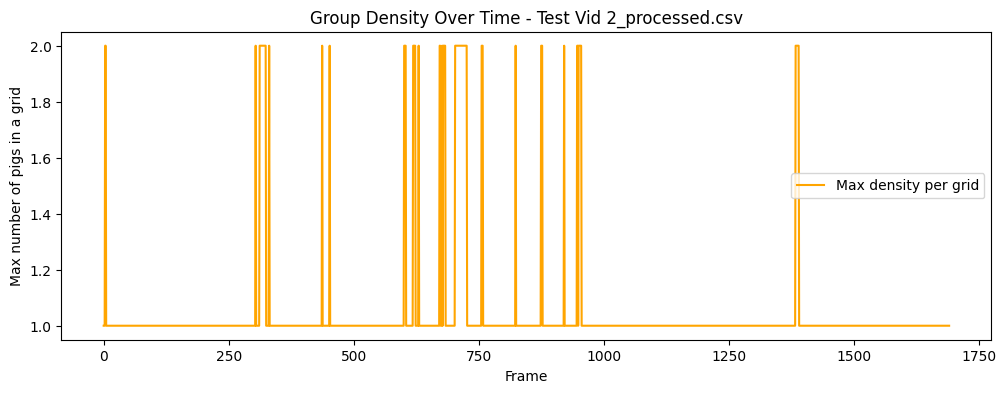


Aggressive Movements Toward Others - Test Vid 2_processed.csv
Pig 1: 13 frames moving aggressively toward others
Pig 2: 1 frames moving aggressively toward others


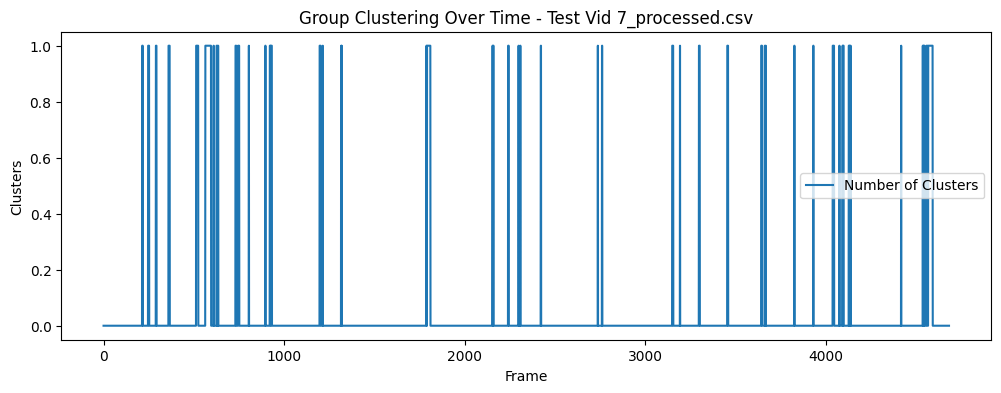

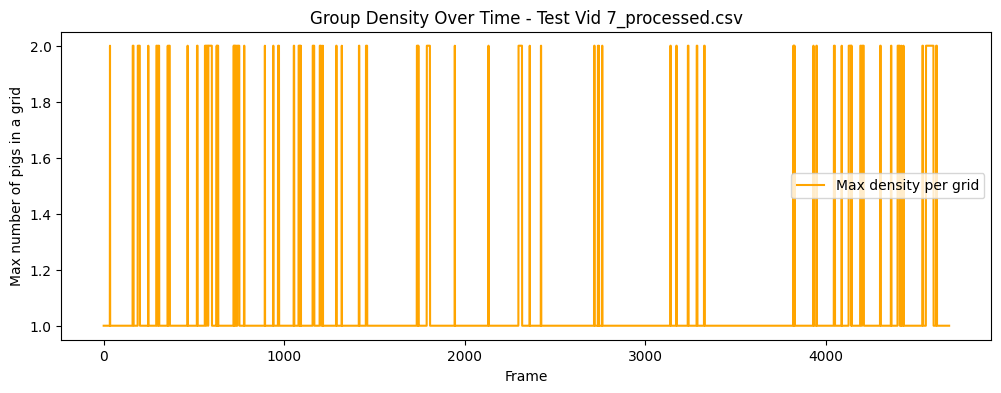


Aggressive Movements Toward Others - Test Vid 7_processed.csv
Pig 1: 28 frames moving aggressively toward others
Pig 2: 21 frames moving aggressively toward others


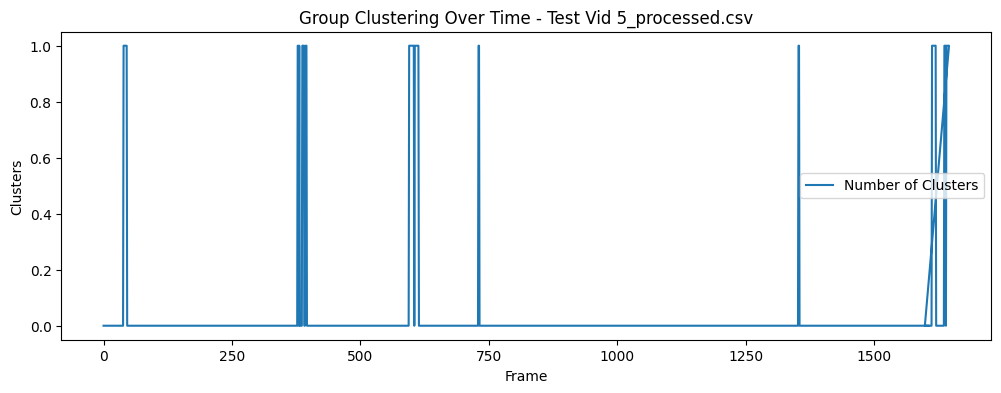

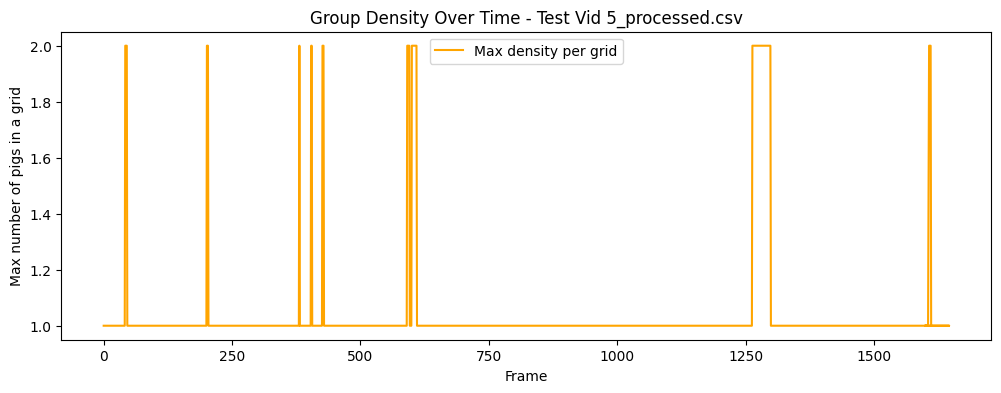


Aggressive Movements Toward Others - Test Vid 5_processed.csv
Pig 1: 15 frames moving aggressively toward others
Pig 2: 12 frames moving aggressively toward others


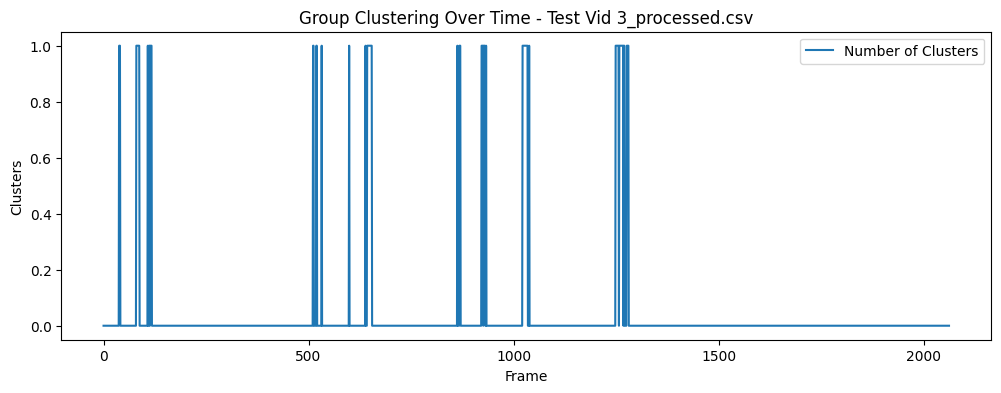

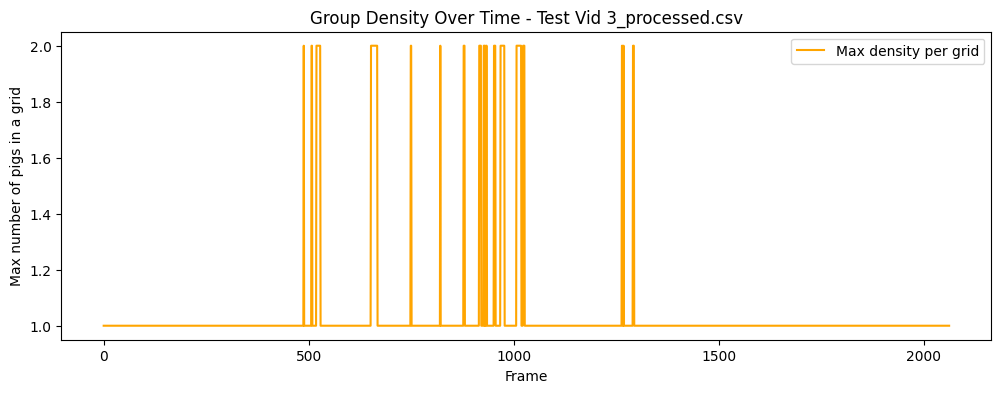


Aggressive Movements Toward Others - Test Vid 3_processed.csv
Pig 1: 4 frames moving aggressively toward others
Pig 2: 5 frames moving aggressively toward others


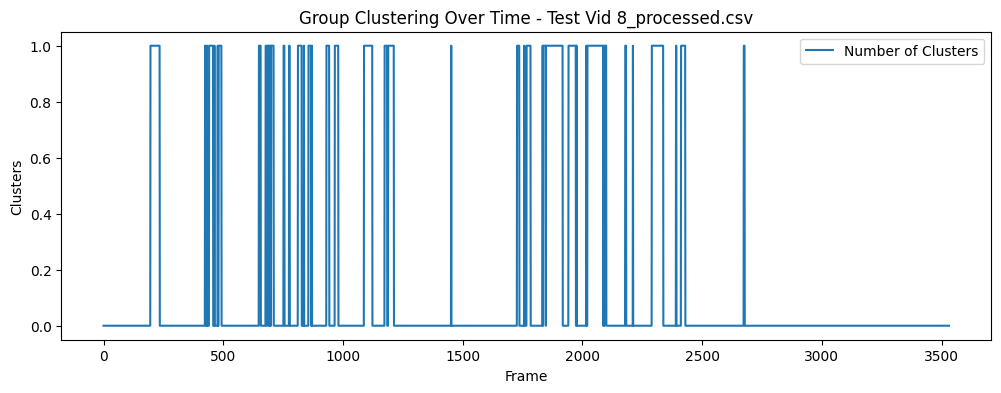

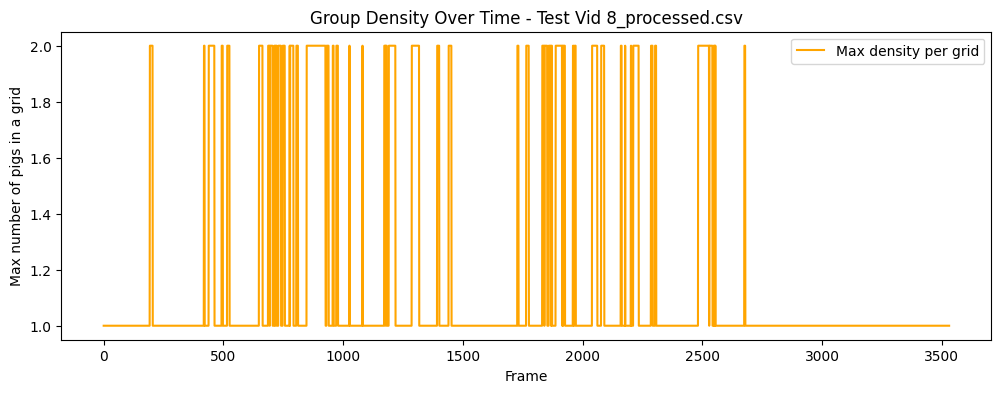


Aggressive Movements Toward Others - Test Vid 8_processed.csv
Pig 1: 2 frames moving aggressively toward others
Pig 2: 2 frames moving aggressively toward others


In [38]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# --- Step 1: Load CSV files ---
folder_path = "/content/0utput_csv/"
csv_files = glob.glob(folder_path + "*_processed.csv")

# Parameters
speed_threshold = 20       # pixels/frame for fast movement
proximity_threshold = 50   # pixels for interaction
eps_cluster = 60           # DBSCAN distance threshold
min_samples = 2            # minimum pigs to form a cluster

# --- Step 2: Process each CSV ---
for file in csv_files:
    df = pd.read_csv(file)

    # Compute centroids
    df['cx'] = (df['x1'] + df['x2']) / 2
    df['cy'] = (df['y1'] + df['y2']) / 2

    # Previous centroids
    df = df.sort_values(by=['object_id','frame_id'])
    df['cx_prev'] = df.groupby('object_id')['cx'].shift(1)
    df['cy_prev'] = df.groupby('object_id')['cy'].shift(1)

    # Compute speed per pig per frame
    df['speed'] = np.sqrt((df['cx'] - df['cx_prev'])**2 + (df['cy'] - df['cy_prev'])**2)
    df['speed'] = df['speed'].fillna(0)

    pig_ids = df['object_id'].unique()
    frames = df['frame_id'].unique()

    # --- Group Clustering & Density ---
    clustering_counts = []
    density_counts = []

    for f in frames:
        df_frame = df[df['frame_id']==f]
        coords = df_frame[['cx','cy']].values

        # DBSCAN clustering
        if len(coords) > 0:
            db = DBSCAN(eps=eps_cluster, min_samples=min_samples).fit(coords)
            labels = db.labels_
            num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            clustering_counts.append(num_clusters)

            # Density estimation: max pigs in a 100x100 grid
            heatmap, xedges, yedges = np.histogram2d(df_frame['cx'], df_frame['cy'], bins=[range(0,1100,100), range(0,900,100)])
            density_counts.append(np.max(heatmap))

    plt.figure(figsize=(12,4))
    plt.plot(frames, clustering_counts, label='Number of Clusters')
    plt.xlabel('Frame')
    plt.ylabel('Clusters')
    plt.title(f'Group Clustering Over Time - {file.split("/")[-1]}')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(frames, density_counts, color='orange', label='Max density per grid')
    plt.xlabel('Frame')
    plt.ylabel('Max number of pigs in a grid')
    plt.title(f'Group Density Over Time - {file.split("/")[-1]}')
    plt.legend()
    plt.show()

    # --- Aggressive Movement Towards Others ---
    aggressive_toward_counts = { pig: 0 for pig in pig_ids }

    for f in frames[1:]:
        df_prev = df[df['frame_id']==f-1].set_index('object_id')
        df_curr = df[df['frame_id']==f].set_index('object_id')

        for i in pig_ids:
            if i not in df_prev.index or i not in df_curr.index:
                continue
            # Pig i movement vector
            v_i = np.array([df_curr.loc[i]['cx'] - df_prev.loc[i]['cx'],
                            df_curr.loc[i]['cy'] - df_prev.loc[i]['cy']])
            speed = np.linalg.norm(v_i)
            if speed < speed_threshold:
                continue
            # Check if moving toward any other pig
            for j in pig_ids:
                if i == j or j not in df_curr.index:
                    continue
                d_ij = np.array([df_curr.loc[j]['cx'] - df_curr.loc[i]['cx'],
                                 df_curr.loc[j]['cy'] - df_curr.loc[i]['cy']])
                if np.linalg.norm(d_ij) == 0:
                    continue
                cos_theta = np.dot(v_i, d_ij) / (np.linalg.norm(v_i) * np.linalg.norm(d_ij))
                if cos_theta > 0.8:  # moving roughly toward the other pig
                    aggressive_toward_counts[i] += 1

    print(f"\nAggressive Movements Toward Others - {file.split('/')[-1]}")
    for pig, count in aggressive_toward_counts.items():
        print(f"Pig {pig}: {count} frames moving aggressively toward others")


## Trajectory Similarity Analysis Using DTW

This code compares pig movement paths using **Dynamic Time Warping (DTW)**.

---

### 1. Import Libraries and Load CSV Files

- `pandas`, `numpy` → Data manipulation  
- `glob` → List all processed CSV files  
- `fastdtw` → Fast Dynamic Time Warping implementation  
- `scipy.spatial.distance.euclidean` → Distance metric for DTW  

---

### 2. Compute Centroids

- Centroid of bounding box:  
$$
cx = \frac{x_1 + x_2}{2}, \quad cy = \frac{y_1 + y_2}{2}
$$

---

### 3. DTW Trajectory Similarity

- For each pair of pigs `(i, j)`:  
  - Extract centroid trajectories:  
  $$
  \text{trajectory}_i = [(cx_i^1, cy_i^1), \dots, (cx_i^T, cy_i^T)]
  $$  
  $$
  \text{trajectory}_j = [(cx_j^1, cy_j^1), \dots, (cx_j^T, cy_j^T)]
  $$

- Compute **DTW distance**:  
$$
\text{DTW\_distance} = \min_{\text{warping path}} \sum_t || \text{trajectory}_i(t) - \text{trajectory}_j(t) ||_2
$$

- Smaller distance → more similar paths (coordination or following behavior)  
- Larger distance → divergent or avoidance behavior  

---

### 4. Display Results

- Print **DTW distance** for each pig pair per video.


In [40]:
!!pip install fastdtw

['Collecting fastdtw',
 '  Downloading fastdtw-0.3.4.tar.gz (133 kB)',
 '\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/133.4 kB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b133.4/133.4 kB\x1b \x1b4.9 MB/s\x1b eta \x1b0:00:00\x1b',
 '\x1b[?25h  Preparing metadata (setup.py) ... \x1b[?25l\x1b[?25hdone',
 'Requirement already satisfied: numpy in /usr/local/lib/python3.12/dist-packages (from fastdtw) (2.0.2)',
 'Building wheels for collected packages: fastdtw',
 '  Building wheel for fastdtw (setup.py) ... \x1b[?25l\x1b[?25hdone',
 '  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp312-cp312-linux_x86_64.whl size=567860 sha256=5ac318ba41faab1c5880a4e75c28624c2fe58bcb3a98b0b64af3c06f39b26824',
 '  Stored in directory: /root/.cache/pip/wheels/ab/d0/26/b82cb0f49ae73e5e6bba4e8462fff2c9851d7bd2ec64f8891e',
 'Successfully built fastdtw',
 'Installing collected packages: fastdtw',
 'Successfully installed fastdt

In [41]:
import pandas as pd
import numpy as np
import glob
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# --- Load CSV files ---
folder_path = "/content/0utput_csv/"
csv_files = glob.glob(folder_path + "*_processed.csv")

for file in csv_files:
    df = pd.read_csv(file)
    df['cx'] = (df['x1'] + df['x2']) / 2
    df['cy'] = (df['y1'] + df['y2']) / 2

    pig_ids = df['object_id'].unique()

    print(f"\nTrajectory Similarity - {file.split('/')[-1]}")
    for i in range(len(pig_ids)):
        for j in range(i+1, len(pig_ids)):
            pig_i = df[df['object_id']==pig_ids[i]][['cx','cy']].values
            pig_j = df[df['object_id']==pig_ids[j]][['cx','cy']].values
            # Compute DTW distance between trajectories
            distance, _ = fastdtw(pig_i, pig_j, dist=euclidean)
            print(f"Pigs {pig_ids[i]} & {pig_ids[j]}: DTW distance = {distance:.2f}")


Trajectory Similarity - Test Vid 1_processed.csv
Pigs 1 & 2: DTW distance = 71592.07

Trajectory Similarity - Test Vid 2_processed.csv
Pigs 1 & 2: DTW distance = 197130.65

Trajectory Similarity - Test Vid 7_processed.csv
Pigs 1 & 2: DTW distance = 344906.74

Trajectory Similarity - Test Vid 5_processed.csv
Pigs 1 & 2: DTW distance = 188610.72

Trajectory Similarity - Test Vid 3_processed.csv
Pigs 1 & 2: DTW distance = 234897.39

Trajectory Similarity - Test Vid 8_processed.csv
Pigs 1 & 2: DTW distance = 438350.34


## Combined Behavior Classification Across All Videos

This notebook cell demonstrates how to combine multiple pig tracking CSV files and train a single **Random Forest** model.

---

### 1. Load & Combine CSV Files

- Load all processed CSVs from a folder  
- Add a `video` column to keep track of the source  
- Concatenate all files into a single `DataFrame`  

---

### 2. Feature Engineering

- **Centroids**:  
$$
cx = \frac{x_1 + x_2}{2}, \quad cy = \frac{y_1 + y_2}{2}
$$
- **Previous frame centroids** (per pig per video) for speed calculation  
- **Speed**:  
$$
\text{speed} = \sqrt{(cx - cx_{\text{prev}})^2 + (cy - cy_{\text{prev}})^2}
$$
- **Distance to nearest pig per frame**:  
$$
\text{nearest\_dist}_i = \min_{j \neq i} \sqrt{(cx_i - cx_j)^2 + (cy_i - cy_j)^2}
$$

---

### 3. Features & Target

- Feature matrix: `X = [speed, nearest_dist]`  
- Target (dummy example):  
$$
y_i =
\begin{cases}
1, & \text{if speed}_i > \text{median speed} \ (\text{Active}) \\
0, & \text{otherwise (Resting)}
\end{cases}
$$

---

### 4. Train/Test Split & Scaling

- Split data: 80% train, 20% test  
- Standardize features using `StandardScaler`  

---

### 5. Random Forest Classification

- Train `RandomForestClassifier` with 100 trees  
- Predict behavior labels for test set  

---

### 6. Evaluation

- **Classification report**: Precision, recall, F1-score  
- **Confusion matrix**: Visualize true vs predicted labels  
- **Optional 5-fold cross-validation F1-score** to validate robustness  



**🔴 Not useful as the training data is too limited 🙅‍♂️**

/tmp/ipython-input-3026406093.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '573.6708551077003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[df_frame.index[idx],'nearest_dist'] = np.min(dists[dists>0]) if len(dists)>1 else 0



Combined Behavior Classification Report:
              precision    recall  f1-score   support

     Resting       1.00      1.00      1.00      2926
      Active       1.00      1.00      1.00      2796

    accuracy                           1.00      5722
   macro avg       1.00      1.00      1.00      5722
weighted avg       1.00      1.00      1.00      5722



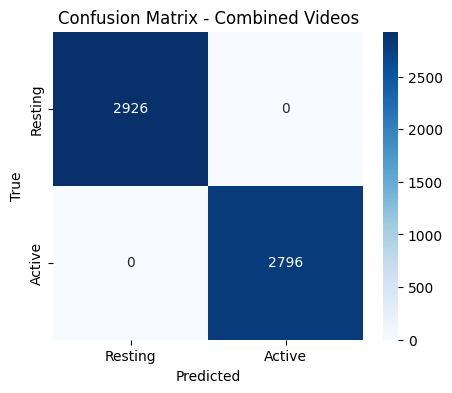

5-fold F1-score: [1. 1. 1. 1. 1.]
Mean F1-score: 1.0


In [44]:
import pandas as pd
import numpy as np
import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load all CSV files and combine ---
folder_path = "/content/0utput_csv/"
csv_files = glob.glob(folder_path + "*_processed.csv")

combined_df = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file)
    df['video'] = file.split("/")[-1]  # keep track of video source
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# --- Step 2: Feature Engineering ---
combined_df['cx'] = (combined_df['x1'] + combined_df['x2']) / 2
combined_df['cy'] = (combined_df['y1'] + combined_df['y2']) / 2

combined_df = combined_df.sort_values(by=['video','object_id','frame_id'])
combined_df['cx_prev'] = combined_df.groupby(['video','object_id'])['cx'].shift(1)
combined_df['cy_prev'] = combined_df.groupby(['video','object_id'])['cy'].shift(1)

# Speed
combined_df['speed'] = np.sqrt((combined_df['cx'] - combined_df['cx_prev'])**2 +
                               (combined_df['cy'] - combined_df['cy_prev'])**2)
combined_df['speed'] = combined_df['speed'].fillna(0)

# Distance to nearest pig per frame
combined_df['nearest_dist'] = 0
frames = combined_df['frame_id'].unique()
for vid in combined_df['video'].unique():
    df_vid = combined_df[combined_df['video']==vid]
    for f in df_vid['frame_id'].unique():
        df_frame = df_vid[df_vid['frame_id']==f]
        coords = df_frame[['cx','cy']].values
        for idx, pig in enumerate(df_frame['object_id']):
            dists = np.linalg.norm(coords - coords[idx], axis=1)
            combined_df.loc[df_frame.index[idx],'nearest_dist'] = np.min(dists[dists>0]) if len(dists)>1 else 0

# --- Step 3: Features and Target ---
X = combined_df[['speed','nearest_dist']].values
y = (combined_df['speed'] > combined_df['speed'].median()).astype(int)  # 1 = active, 0 = resting

# --- Step 4: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Step 5: Train Random Forest Classifier ---
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# --- Step 6: Evaluate ---
y_pred = clf.predict(X_test)
print("\nCombined Behavior Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Resting','Active']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Resting','Active'], yticklabels=['Resting','Active'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Combined Videos')
plt.show()

# Optional: 5-fold cross-validation F1-score
scores = cross_val_score(clf, X, y, cv=5, scoring='f1')
print("5-fold F1-score:", scores)
print("Mean F1-score:", scores.mean())

## Social Interaction Network

This cell builds a **social network** from pig tracking data using proximity interactions.

---

### 1. Compute Centroids
If not already present, calculate centroid coordinates of each bounding box:

$$
cx = \frac{x_1 + x_2}{2}, \quad cy = \frac{y_1 + y_2}{2}
$$

---

### 2. Prepare for Network Analysis
- List all `pig_ids` and frames.  
- Set a **proximity threshold** (pixels) to define interaction.  
- Initialize interaction counts between pig pairs:

$$
\text{interaction\_counts}_{(i,j)} = 0
$$

---

### 3. Count Proximity Interactions
For each frame:

- Compute Euclidean distance between pig centroids:  
$$
d_{ij} = \sqrt{(cx_i - cx_j)^2 + (cy_i - cy_j)^2}
$$
- If distance ≤ threshold, increment the interaction count.

---

### 4. Build Graph
- Nodes = pigs  
- Edges = presence of interactions  
- Edge weights = number of interactions

---

### 5. Draw Network
- Use `networkx.circular_layout` for node positions  
- Edge thickness proportional to interaction frequency


**🔴 Not very useful, as there are only two pigs in the whole video frame 🙅‍♂️**

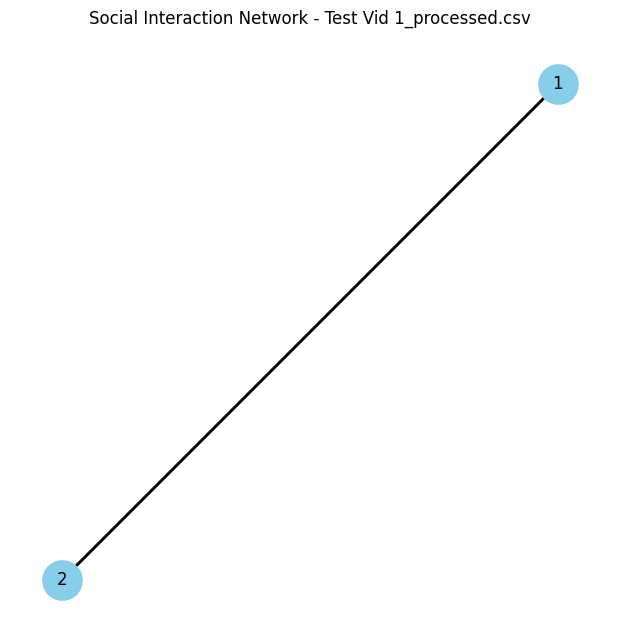

In [46]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Load CSV
csv_path = "/content/0utput_csv/Test Vid 1_processed.csv"
df = pd.read_csv(csv_path)

# --- Step 1: Compute centroids if not already done ---
if 'cx' not in df.columns or 'cy' not in df.columns:
    df['cx'] = (df['x1'] + df['x2']) / 2
    df['cy'] = (df['y1'] + df['y2']) / 2

# --- Step 2: Prepare for social network ---
pig_ids = df['object_id'].unique()
frames = df['frame_id'].unique()
proximity_threshold = 50
interaction_counts = { (i,j):0 for i in pig_ids for j in pig_ids if i<j }

# --- Step 3: Count proximity interactions ---
for f in frames:
    df_frame = df[df['frame_id']==f]
    pigs = df_frame['object_id'].values
    coords = df_frame[['cx','cy']].values
    for i in range(len(pigs)):
        for j in range(i+1, len(pigs)):
            dist = np.linalg.norm(coords[i] - coords[j])
            if dist <= proximity_threshold:
                interaction_counts[(pigs[i], pigs[j])] += 1

# --- Step 4: Build graph ---
G = nx.Graph()
for pig in pig_ids:
    G.add_node(pig)
for (i,j), count in interaction_counts.items():
    if count>0:
        G.add_edge(i,j,weight=count)

# --- Step 5: Draw network ---
pos = nx.circular_layout(G)
edges = G.edges(data=True)
weights = [edata['weight'] for _,_,edata in edges]

plt.figure(figsize=(6,6))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=800, width=np.array(weights)/10)
plt.title(f'Social Interaction Network - {csv_path.split("/")[-1]}')
plt.show()